In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import requests
#import ydata profiling
from ydata_profiling import ProfileReport
import numpy as np
import re

In [2]:
# import religion and election excel file:

df_rv = pd.read_excel('ReligionData.xlsx',sheet_name='Religion and Election Data')
pd.set_option('display.max_columns', None)
df_rv = df_rv.fillna(0)

# remove columns:

df_rv = df_rv[df_rv.columns.drop(list(df_rv.filter(regex='per Thousand')))]
df_rv = df_rv[df_rv.columns.drop(list(df_rv.filter(regex='Per Thousand')))]
df_rv = df_rv[df_rv.columns.drop(list(df_rv.filter(regex='Buddhism')))]
df_rv = df_rv.drop([
'Indian-American Hindu Adherents',
'Post Renaissance Hindu Adherents',
'Renaissance Hindu Adherents',
'Traditional Hindu Temples Adherents',
'Conservative Judaism Adherents',
'Orthodox Judaism Adherents',
'Reconstructionist Judaism Adherents',
'Reform Judaism Adherents'], axis=1)

# create state mapping dictionary:

us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
}

In [3]:
# make updates to df_rv dataframe:

df_rv['State Code'] = df_rv.replace({'State Code':us_state_abbrev})  # update State Code with full state name
df_rv['County Name'] = df_rv['County Name'].map(str) + ', ' + df_rv['State Code'].map(str) # concatenate county and state

# rename df_rv columns:

df_rv.rename(columns={'Clinton or Trump State':'Party Affiliation',
                     'Clinton':'Democrat','Trump':'Republican',
                     '% Clinton':'% Democrat','% Trump':'% Republican',
                     'County Name':'Geographic Area Name',
                     'State Code':'State_Code'}, inplace=True)

# update Party Affiliation:

df_rv['Party Affiliation'] = df_rv['Party Affiliation'].replace({'Trump':'Republican','Clinton':'Democrat'})


In [4]:
    # df_rv.head()
# print(df_rv.info())

# print(df_dem.info()) # Geographic Area Name 838 non-null object
# df_dem['Geographic Area Name'].unique

df_rv['Geographic Area Name'].unique

<bound method Series.unique of 0        Autauga County, Alabama
1        Baldwin County, Alabama
2        Barbour County, Alabama
3           Bibb County, Alabama
4         Blount County, Alabama
                  ...           
3108       Teton County, Wyoming
3109       Uinta County, Wyoming
3110    Washakie County, Wyoming
3111      Weston County, Wyoming
3112              Alaska, Alaska
Name: Geographic Area Name, Length: 3113, dtype: object>

In [5]:
print(df_rv.dtypes)
    
chk = df_rv.select_dtypes(include ='object')
chk.columns

State_Code                                     object
Geographic Area Name                           object
County Population                             float64
Party Affiliation                              object
Democrat                                        int64
Republican                                      int64
Total                                           int64
% Democrat                                    float64
% Republican                                  float64
Vote Difference C-T                             int64
Vote Difference T-C                             int64
Percent Difference C-T                        float64
Percent Difference T-C                        float64
Obama                                           int64
Romney                                          int64
2012 Total Votes                                int64
% Obama                                       float64
% Romney                                      float64
Vote Difference O-R         

Index(['State_Code', 'Geographic Area Name', 'Party Affiliation',
       'Combined FIPS Code', 'ANSI Code', 'CBSA Title',
       'Metropolitan/Micropolitan Statistical Area', 'CSA Title',
       'Metropolitan Division Title', 'Central/Outlying County'],
      dtype='object')

In [6]:
df_rv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   State_Code                                  3113 non-null   object 
 1   Geographic Area Name                        3113 non-null   object 
 2   County Population                           3113 non-null   float64
 3   Party Affiliation                           3113 non-null   object 
 4   Democrat                                    3113 non-null   int64  
 5   Republican                                  3113 non-null   int64  
 6   Total                                       3113 non-null   int64  
 7   % Democrat                                  3113 non-null   float64
 8   % Republican                                3113 non-null   float64
 9   Vote Difference C-T                         3113 non-null   int64  
 10  Vote Differe

In [7]:
df_rv[df_rv['State_Code']=='Alabama']
# df_rv['Party Affiliation'].unique()

,State_Code,Geographic Area Name,County Population,Party Affiliation,Democrat,Republican,Total,% Democrat,% Republican,Vote Difference C-T,Vote Difference T-C,Percent Difference C-T,Percent Difference T-C,Obama,Romney,2012 Total Votes,% Obama,% Romney,Vote Difference O-R,% Difference O-R,Clinton B(W) Obama,Trump B(W) Romney,Clinton % B(W) Obama,Trump % B(W) Romney,2010 Land Area,Density,Combined FIPS Code,ANSI Code,State FIPS Code,County FIPS Code,CBSA Code,CSA Code,CBSA Title,CBSA Population,Metropolitan/Micropolitan Statistical Area,CSA Title,Metropolitan Division Title,Metropolitan Division Code,Central/Outlying County,POP2010,Total Congregations,Total Adherents,Evangelical Protestant Adherents,Black Protestant Adherents,Mainline Protestant Adherents,Catholic Adherents,Orthodox Adherents,Baha'I Adherents,Total Buddhist Adherents,Latter Day Saints Adherents,Total Hindu Adherents,Muslims Estimated,Total Judaism Adherents,Unitarian Universalist Adherents,Zoroastrian Adherents
0,Alabama,"Autauga County, Alabama",55347.0,Republican,5908,18110,24661,0.239569,0.734358,-12202,12202,-0.494789,0.494789,6354,17366,23909,0.265758,0.726337,-11012,-0.460580,-446,744,-0.026189,0.008021,594.44,93.107799,1001,01001,1.0,1.0,33860.0,0.0,"Montgomery, AL",373792.0,Metropolitan Statistical Area,0,0,0.0,Central,54571.0,106.0,36938.0,27503.0,2291.0,4522.0,1766.0,0.0,33.0,0.0,820.0,0.0,0.0,0.0,0.0,3.0
1,Alabama,"Baldwin County, Alabama",203709.0,Republican,18409,72780,94090,0.195653,0.773515,-54371,54371,-0.577862,0.577862,18329,65772,84988,0.215666,0.773897,-47443,-0.558232,80,7008,-0.020013,-0.000383,1589.78,128.136598,1003,01003,1.0,3.0,19300.0,380.0,"Daphne-Fairhope-Foley, AL",203709.0,Metropolitan Statistical Area,"Mobile-Daphne-Fairhope, AL",0,0.0,Central,182265.0,271.0,96918.0,57986.0,3130.0,20075.0,14009.0,190.0,37.0,0.0,1022.0,0.0,0.0,0.0,146.0,0.0
2,Alabama,"Barbour County, Alabama",26489.0,Republican,4848,5431,10390,0.466603,0.522714,-583,583,-0.056112,0.056112,5873,5539,11459,0.512523,0.483376,334,0.029147,-1025,-108,-0.045920,0.039339,884.88,29.935132,1005,01005,1.0,5.0,21640.0,0.0,"Eufaula, AL-GA",0.0,Micropolitan Statistical Area,0,0,0.0,Central,27457.0,89.0,15101.0,8793.0,3328.0,2140.0,575.0,0.0,0.0,0.0,265.0,0.0,0.0,0.0,0.0,0.0
3,Alabama,"Bibb County, Alabama",22583.0,Republican,1874,6733,8748,0.214220,0.769662,-4859,4859,-0.555441,0.555441,2200,6131,8391,0.262186,0.730664,-3931,-0.468478,-326,602,-0.047965,0.038998,622.58,36.273250,1007,01007,1.0,7.0,13820.0,142.0,"Birmingham-Hoover, AL",1145647.0,Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",0,0.0,Outlying,22915.0,81.0,11430.0,10159.0,966.0,302.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Alabama,"Blount County, Alabama",57673.0,Republican,2150,22808,25384,0.084699,0.898519,-20658,20658,-0.813820,0.813820,2961,20741,23980,0.123478,0.864929,-17780,-0.741451,-811,2067,-0.038779,0.033590,644.78,89.446013,1009,01009,1.0,9.0,13820.0,142.0,"Birmingham-Hoover, AL",1145647.0,Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",0,0.0,Outlying,57322.0,156.0,37352.0,29223.0,58.0,3035.0,4744.0,0.0,1.0,0.0,291.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,Alabama,"Tuscaloosa County, Alabama",203976.0,Republican,31746,47701,81708,0.388530,0.583798,-15955,15955,-0.195269,0.195269,32003,45703,78495,0.407707,0.582241,-13700,-0.174533,-257,1998,-0.019178,0.001557,1321.76,154.321511,1125,01125,1.0,125.0,46220.0,0.0,"Tuscaloosa, AL",239908.0,Metropolitan Statistical Area,0,0,0.0,Central,194656.0,311.0,104315.0,71803.0,14428.0,12415.0,3729.0,0.0,109.0,0.0,1246.0,0.0,308.0,178.0,99.0,0.0
63,Alabama,"Walker County, Alabama",65294.0,Republican,4486,24208,29243,0.153404,0.827822,-19722,19722,-0.674418,0.674418,6551,21633,28497,0.229884,0.759133,-15082,-0.529249,-2065,2575,-0.07

In [8]:
# import demographic and housing estimates csv:

df_dem = pd.read_csv('2018 ACS DP05 Demographic and Housing Estimates.csv',header=1)
df_dem = df_dem[df_dem.columns.drop(list(df_dem.filter(regex='Margin of Error!!')))]  # drop columns with MoE
df_dem = df_dem[df_dem.columns.drop(list(df_dem.filter(regex='Percent Estimate!!')))] # drop columns with PctEst
pd.set_option('display.max_columns', None)
df_dem = df_dem.fillna(0) # update nan columns with zero


# replace invalid values:

c = df_dem.columns[2:]
for x in c:
    df_dem[x].replace('N',0,inplace=True)
    df_dem[x].replace('(X)',0,inplace=True)
    df_dem[x].replace('None',0,inplace=True)

# change data types:

c = df_dem.columns[35:]
for x in c:
    df_dem[x] = df_dem[x].astype(int)

# df_dem.apply(pd.to_numeric, errors='ignore')
    
df_dem.head()

,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!SEX AND AGE!!Total population!!Under 18 years,Estimate!!SEX AND AGE!!Total population!!16 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!21 years and over,Estimate!!SEX AND AGE!!Total population!!62 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over.1,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!65 years and over.1,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Estimate!!RACE!!Total population,Estimate!!RACE!!Total population!!One race,Estimate!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race.1,Estimate!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Estimate!!RACE!!Total population!!One race!!Asian,Estimate!!RACE!!Total population!!One race!!Asian!!Asian Indian,Estimate!!RACE!!Total population!!One race!!Asian!!Chinese,Estimate!!RACE!!Total population!!One race!!Asian!!Filipino,Estimate!!RACE!!Total population!!One race!!Asian!!Japanese,Estimate!!RACE!!Total population!!One race!!Asian!!Korean,Estimate!!RACE!!Total population!!One race!!Asian!!Vietnamese,Estimate!!RACE!!Total population!!One race!!Asian!!Other Asian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Guamanian or Chamorro,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Some other race,Estimate!!RACE!!Total population!!Two or more races.1,Estimate!!RACE!!Total population!!Two or more races!!White and Black or African American,Estimate!!RACE!!Total population!!Two or more races!!White and American Indian and Al

In [9]:
# check to see if there are any df_dem objects:

print(df_dem.dtypes)
    
chk1 = df_dem.select_dtypes(include ='object')
chk1.columns

id                                                                                                                                                                  object
Geographic Area Name                                                                                                                                                object
Estimate!!SEX AND AGE!!Total population                                                                                                                              int64
Estimate!!SEX AND AGE!!Total population!!Male                                                                                                                        int64
Estimate!!SEX AND AGE!!Total population!!Female                                                                                                                      int64
                                                                                                                                                 

Index(['id', 'Geographic Area Name'], dtype='object')

In [5]:
# import housing characteristics csv:

df_hou = pd.read_csv('2018 ACS DP04 Housing Characteristics.csv',header=1)
df_hou = df_hou[df_hou.columns.drop(list(df_hou.filter(regex='Margin of Error!!')))]
df_hou = df_hou[df_hou.columns.drop(list(df_hou.filter(regex='Percent Estimate!!')))]
pd.set_option('display.max_columns', None)
df_hou = df_hou.fillna(0)

# replace invalid values:

c = df_hou.columns[2:]
for x in c:
    df_hou[x].replace('N',0,inplace=True)
    df_hou[x].replace('(X)',0,inplace=True)
    df_hou[x].replace('None',0,inplace=True)
    
    
df_hou['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate'] = df_hou['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate'].astype(float)

df_hou['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate'] = df_hou['Estimate!!HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate'].astype(float)

# change data types for df_hou objects:

c1 = df_hou.select_dtypes(include ='object')
c1.columns[2:]


# change data types to int
c = c1.columns[2:]
for x in c:
    df_hou[x] = df_hou[x].astype(int)
    
df_hou.head()

,id,Geographic Area Name,Estimate!!BEDROOMS!!Total housing units!!1 bedroom,Estimate!!BEDROOMS!!Total housing units!!2 bedrooms,Estimate!!BEDROOMS!!Total housing units!!3 bedrooms,Estimate!!BEDROOMS!!Total housing units!!4 bedrooms,Estimate!!BEDROOMS!!Total housing units!!5 or more bedrooms,Estimate!!HOUSING TENURE!!Occupied housing units,Estimate!!HOUSING TENURE!!Occupied housing units!!Owner-occupied,Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied,Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of owner-occupied unit,Estimate!!HOUSING TENURE!!Occupied housing units!!Average household size of renter-occupied unit,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2017 or later,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2015 to 2016,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2010 to 2014,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 2000 to 2009,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1990 to 1999,Estimate!!YEAR HOUSEHOLDER MOVED INTO UNIT!!Occupied housing units!!Moved in 1989 and earlier,Estimate!!VEHICLES AVAILABLE!!Occupied housing units,Estimate!!VEHICLES AVAILABLE!!Occupied housing units!!No vehicles available,Estimate!!VEHICLES AVAILABLE!!Occupied housing units!!1 vehicle available,Estimate!!VEHICLES AVAILABLE!!Occupied housing units!!2 vehicles available,Estimate!!VEHICLES AVAILABLE!!Occupied housing units!!3 or more vehicles available,Estimate!!HOUSE HEATING FUEL!!Occupied housing units,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Utility gas,"Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Bottled, tank, or LP gas",Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Electricity,"Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Fuel oil, kerosene, etc.",Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Coal or coke,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Wood,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Solar energy,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!Other fuel,Estimate!!HOUSE HEATING FUEL!!Occupied housing units!!No fuel used,Estimate!!SELECTED CHARACTERISTICS!!Occupied housing units,Estimate!!SELECTED CHARACTERISTICS!!Occupied housing units!!Lacking complete plumbing facilities,Estimate!!SELECTED CHARACTERISTICS!!Occupied housing units!!Lacking complete kitchen facilities,Estimate!!SELECTED CHARACTERISTICS!!Occupied housing units!!No telephone service available,Estimate!!OCCUPANTS PER ROOM!!Occupied housing units,Estimate!!OCCUPANTS PER ROOM!!Occupied housing units!!1.00 or less,Estimate!!OCCUPANTS PER ROOM!!Occupied housing units!!1.01 to 1.50,Estimate!!OCCUPANTS PER ROOM!!Occupied housing units!!1.51 or more,Estimate!!VALUE!!Owner-occupied units,"Estimate!!VALUE!!Owner-occupied units!!Less than $50,000","Estimate!!VALUE!!Owner-occupied units!!$50,000 to $99,999","Estimate!!VALUE!!Owner-occupied units!!$100,000 to $149,999","Estimate!!VALUE!!Owner-occupied units!!$150,000 to $199,999","Estimate!!VALUE!!Owner-occupied units!!$200,000 to $299,999","Estimate!!VALUE!!Owner-occupied units!!$300,000 to $499,999","Estimate!!VALUE!!Owner-occupied units!!$500,000 to $999,999","Estimate!!VALUE!!Owner-occupied units!!$1,000,000 or more",Estimate!!VALUE!!Owner-occupied units!!Median (dollars),Estimate!!MORTGAGE STATUS!!Owner-occupied units,Estimate!!MORTGAGE STATUS!!Owner-occupied units!!Housing units with a mortgage,Estimate!!MORTGAGE STATUS!!Owner-occupied units!!Housing units without a mortgage,Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units with a mortgage,Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units with a mortgage!!Less than $500,Estimate!!SELECTED MONTHLY OWNER COSTS (SMOC)!!Housing units with a mortgage!!$500 to $999,"Estimate!!SELECTED MONTHLY OWNER COSTS 

In [7]:
# check to see if data type modification took place:

print(df_hou.dtypes)

chk2 = df_hou.select_dtypes(include ='object')
chk2.columns

id                                                        object
Geographic Area Name                                      object
Estimate!!BEDROOMS!!Total housing units!!1 bedroom         int64
Estimate!!BEDROOMS!!Total housing units!!2 bedrooms        int64
Estimate!!BEDROOMS!!Total housing units!!3 bedrooms        int64
                                                          ...   
Estimate!!ROOMS!!Total housing units!!8 rooms              int64
Estimate!!ROOMS!!Total housing units!!9 rooms or more      int64
Estimate!!ROOMS!!Total housing units!!Median rooms       float64
Estimate!!BEDROOMS!!Total housing units                    int64
Estimate!!BEDROOMS!!Total housing units!!No bedroom        int64
Length: 145, dtype: object


Index(['id', 'Geographic Area Name'], dtype='object')

In [ ]:
pd.set_option('display.max_rows', None)
df_hou.dtypes

In [ ]:
# c1.columns[4:]
# c1.columns[2:4]
# df_hou.select_dtypes(include ='object')

In [8]:
# import economic charateristics csv:

df_econ = pd.read_csv('2018 ACS DP03 Economic Characteristics.csv',header=1)
df_econ = df_econ[df_econ.columns.drop(list(df_econ.filter(regex='Margin of Error!!')))]
df_econ = df_econ[df_econ.columns.drop(list(df_econ.filter(regex='Percent Estimate!!')))]
pd.set_option('display.max_columns', None)
df_econ = df_econ.fillna(0)

# replace invalid values:

c = df_econ.columns[2:]
for x in c:
    df_econ[x].replace('N',0,inplace=True)
    df_econ[x].replace('(X)',0,inplace=True)
    df_econ[x].replace('None',0,inplace=True)
    
    
# change data types for df_hou objects:

c1 = df_econ.select_dtypes(include ='object')
c1.columns[2:]


# # change data types to float
# c = c1.columns[2:4]
# for x in c:
#     df_econ[x] = df_econ[x].astype(float)

    
# change data types to int
c = c1.columns[2:]
for x in c:
    df_econ[x] = df_econ[x].astype(int)
    
df_econ.head()

,id,Geographic Area Name,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force,Estimate!!EMPLOYMENT STATUS!!Civilian labor force,Estimate!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate,Estimate!!EMPLOYMENT STATUS!!Females 16 years and over,Estimate!!EMPLOYMENT STATUS!!Females 16 years and over!!In labor force,Estimate!!EMPLOYMENT STATUS!!Females 16 years and over!!In labor force!!Civilian labor force,Estimate!!EMPLOYMENT STATUS!!Females 16 years and over!!In labor force!!Civilian labor force!!Employed,Estimate!!EMPLOYMENT STATUS!!Own children of the householder under 6 years,Estimate!!EMPLOYMENT STATUS!!Own children of the householder under 6 years!!All parents in family in labor force,Estimate!!EMPLOYMENT STATUS!!Own children of the householder 6 to 17 years,Estimate!!EMPLOYMENT STATUS!!Own children of the householder 6 to 17 years!!All parents in family in labor force,Estimate!!COMMUTING TO WORK!!Workers 16 years and over,"Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- drove alone","Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- carpooled",Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab),Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Walked,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Other means,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Worked at home,Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Mean travel time to work (minutes),Estimate!!OCCUPATION!!Civilian employed population 16 years and over,"Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Management, business, science, and arts occupations",Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Service occupations,Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Sales and office occupations,"Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Natural resources, construction, and maintenance occupations","Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Production, transportation, and material moving occupations",Estimate!!INDUSTRY!!Civilian employed population 16 years and over,"Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Agriculture, forestry, fishing and hunting, and mining",Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Construction,Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Manufacturing,Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Wholesale trade,Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Retail trade,"Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Transportation and warehousing, and utilities",Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Information,"Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Finance and insurance, and real estate and rental and leasing","Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Professional, scientific, and management, and administrative and waste management services","Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Educational services, and health care and social assistance","Estimate!!INDUSTRY!!Civilian employed population 16 years and over!!Arts, entertainment, and recreation, and accommodation and food ser

In [9]:
chk3 = df_econ.select_dtypes(include ='object')
chk3.columns

Index(['id', 'Geographic Area Name'], dtype='object')

In [10]:
# import social characteristics csv:

df_soc = pd.read_csv('2018 ACS DP02 Social Characteristics.csv',header=1)
df_soc = df_soc[df_soc.columns.drop(list(df_soc.filter(regex='Margin of Error!!')))]
df_soc = df_soc[df_soc.columns.drop(list(df_soc.filter(regex='Percent Estimate!!')))]
pd.set_option('display.max_columns', None)
df_soc = df_soc.fillna(0)

# replace invalid values:

c = df_soc.columns[2:]
for x in c:
    df_soc[x].replace('N',0,inplace=True)
    df_soc[x].replace('(X)',0,inplace=True)
    df_soc[x].replace('None',0,inplace=True)
    
c1 = df_soc.select_dtypes(include ='object')
c1.columns[2:]


# # change data types to float
# c = c1.columns[2:4]
# for x in c:
#     df_econ[x] = df_econ[x].astype(float)

    
# change data types to int
c = c1.columns[2:]
for x in c:
    df_soc[x] = df_soc[x].astype(int)
    
df_soc.head()

,id,Geographic Area Name,Estimate!!HOUSEHOLDS BY TYPE!!Total households,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families),Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!With own children of the householder under 18 years,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Married-couple family,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Married-couple family!!With own children of the householder under 18 years,"Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Male householder, no wife present, family","Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Male householder, no wife present, family!!With own children of the householder under 18 years","Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Female householder, no husband present, family","Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!Female householder, no husband present, family!!With own children of the householder under 18 years",Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Nonfamily households,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Nonfamily households!!Householder living alone,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Nonfamily households!!Householder living alone!!65 years and over,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Households with one or more people under 18 years,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Households with one or more people 65 years and over,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Average household size,Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Average family size,Estimate!!RELATIONSHIP!!Population in households,Estimate!!RELATIONSHIP!!Population in households!!Householder,Estimate!!RELATIONSHIP!!Population in households!!Spouse,Estimate!!RELATIONSHIP!!Population in households!!Child,Estimate!!RELATIONSHIP!!Population in households!!Other relatives,Estimate!!RELATIONSHIP!!Population in households!!Nonrelatives,Estimate!!RELATIONSHIP!!Population in households!!Nonrelatives!!Unmarried partner,Estimate!!MARITAL STATUS!!Males 15 years and over,Estimate!!MARITAL STATUS!!Males 15 years and over!!Never married,"Estimate!!MARITAL STATUS!!Males 15 years and over!!Now married, except separated",Estimate!!MARITAL STATUS!!Males 15 years and over!!Separated,Estimate!!MARITAL STATUS!!Males 15 years and over!!Widowed,Estimate!!MARITAL STATUS!!Males 15 years and over!!Divorced,Estimate!!MARITAL STATUS!!Females 15 years and over,Estimate!!MARITAL STATUS!!Females 15 years and over!!Never married,"Estimate!!MARITAL STATUS!!Females 15 years and over!!Now married, except separated",Estimate!!MARITAL STATUS!!Females 15 years and over!!Separated,Estimate!!MARITAL STATUS!!Females 15 years and over!!Widowed,Estimate!!MARITAL STATUS!!Females 15 years and over!!Divorced,Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months,"Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Unmarried women (widowed, divorced, and never married)","Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Unmarried women (widowed, divorced, and never married)!!Per 1,000 unmarried women","Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Per 1,000 women 15 to 50 years old","Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Per 1,000 women 15 to 19 years old","Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Per 1,000 women 20 to 34 years old","Estimate!!FERTILITY!!Number of women 15 to 50 years old who had a birth in the past 12 months!!Per 1,000 women 35 to 50 years old",Estimate!!GRANDPARENTS!!Number of grandparents living with own grandchildren under 18 years,

In [11]:
df_soc.dtypes
chk4 = df_soc.select_dtypes(include ='object')
chk4.columns

Index(['id', 'Geographic Area Name'], dtype='object')

In [65]:
# scrape legalization status by state:

url = "https://disa.com/map-of-marijuana-legality-by-state"
html = urlopen(url)
soup = BeautifulSoup(html)

# use getText()to extract the text we need into a list:
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
    
    
# avoid the first header row:
rows = soup.findAll('tr')[1:]

r = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]


state_laws = pd.DataFrame(r, columns = headers)
state_laws = state_laws.drop(columns='State Laws')


# remove asterisks from multiple column values:

for x in state_laws.columns[1:]:
    state_laws[x].replace(regex=["\*"],value='',inplace=True)


state_laws.rename(columns={'State':'State_Code'}, inplace=True)
state_laws.head(100)

,State_Code,Legal Status,Medicinal,Decriminalized
0,Alabama,Fully Illegal,No,No
1,Alaska,Fully Legal,Yes,Yes
2,Arizona,Mixed,Yes,No
3,Arkansas,Mixed,Yes,No
4,California,Fully Legal,Yes,Yes
5,Colorado,Fully Legal,Yes,Yes
6,Connecticut,Mixed,Yes,Reduced
7,Delaware,Mixed,Yes,Reduced
8,District of Columbia,Fully Legal,Yes,Yes
9,Florida,Mixed,Yes,No


In [ ]:
# import PRRI excel file:

df_prri = pd.read_excel('PRRI_Religion.xlsx',sheet_name='Sheet 1',header=2)
pd.set_option('display.max_columns', None)
df_prri = df_prri.fillna(0)
df_prri = df_prri.drop(columns='Unnamed: 0')

In [ ]:
# check df_prri:

df_prri.head()

In [14]:
# create merged dataframe:

df_merge = pd.merge(df_dem, df_hou, on=['id', 'Geographic Area Name'])
df_merge = pd.merge(df_merge, df_econ, on=['id', 'Geographic Area Name'])
df_merge = pd.merge(df_merge, df_soc, on=['id', 'Geographic Area Name'])

In [ ]:
pd.set_option('display.max_columns', None)
df_merge.info()
print(len(df_merge['Geographic Area Name']))
# df_merge['Geographic Area Name'].info()

In [15]:
# assign state to dataframe:

w = []
for x in df_merge['Geographic Area Name']:
#     w.append(re.split(r',',x))
    splitting = x.split(',')
    last = splitting[1]
    l = last.strip()
    w.append(l)

df_merge['State_Code'] = w

# replace name of NM county:

df_merge['Geographic Area Name'].replace('Doña Ana County, New Mexico','Dona Ana County, New Mexico',inplace=True)


In [16]:
# check df_merge:
pd.set_option('display.max_rows', None)
df_merge.dtypes

id                                                                                                                                                                                                                                                                                        object
Geographic Area Name                                                                                                                                                                                                                                                                      object
Estimate!!SEX AND AGE!!Total population                                                                                                                                                                                                                                                    int64
Estimate!!SEX AND AGE!!Total population!!Male                                                                                        

In [17]:
df1 = pd.merge(df_merge, df_rv, on= ['Geographic Area Name'],how='left')
df1.drop(columns=(['State_Code_y']),inplace = True)
df1.rename(columns={'State_Code_x':'State_Code'}, inplace=True)

c = df1.columns[1:]
for x in c:
    df1[x].replace('!','',inplace=True)
    df1[x].replace('"','',inplace=True)

df1.head()

,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!SEX AND AGE!!Total population!!Under 18 years,Estimate!!SEX AND AGE!!Total population!!16 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!21 years and over,Estimate!!SEX AND AGE!!Total population!!62 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over.1,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!65 years and over.1,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Estimate!!RACE!!Total population,Estimate!!RACE!!Total population!!One race,Estimate!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race.1,Estimate!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Estimate!!RACE!!Total population!!One race!!Asian,Estimate!!RACE!!Total population!!One race!!Asian!!Asian Indian,Estimate!!RACE!!Total population!!One race!!Asian!!Chinese,Estimate!!RACE!!Total population!!One race!!Asian!!Filipino,Estimate!!RACE!!Total population!!One race!!Asian!!Japanese,Estimate!!RACE!!Total population!!One race!!Asian!!Korean,Estimate!!RACE!!Total population!!One race!!Asian!!Vietnamese,Estimate!!RACE!!Total population!!One race!!Asian!!Other Asian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Guamanian or Chamorro,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Some other race,Estimate!!RACE!!Total population!!Two or more races.1,Estimate!!RACE!!Total population!!Two or more races!!White and Black or African American,Estimate!!RACE!!Total population!!Two or more races!!White and American Indian and Al

In [18]:
print(df_merge.dtypes)
    
chk5 = df_merge.select_dtypes(include ='object')
chk5.columns

id                                                                                                                                                                                                                                                                                        object
Geographic Area Name                                                                                                                                                                                                                                                                      object
Estimate!!SEX AND AGE!!Total population                                                                                                                                                                                                                                                    int64
Estimate!!SEX AND AGE!!Total population!!Male                                                                                        

Index(['id', 'Geographic Area Name', 'State_Code'], dtype='object')

In [19]:
df = pd.merge(df1, state_laws, on= ['State_Code'])
df.head()

# print(state_laws.dtypes)
# df1.dtypes

# print(df1['State_Code'].unique())
# print(state_laws['State_Code'].unique())

# df.drop(columns=(['State Code_y']),inplace = True)
# df.rename(columns={'State Code_x':'State Code'}, inplace=True)

,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,Estimate!!SEX AND AGE!!Total population!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!Under 5 years,Estimate!!SEX AND AGE!!Total population!!5 to 9 years,Estimate!!SEX AND AGE!!Total population!!10 to 14 years,Estimate!!SEX AND AGE!!Total population!!15 to 19 years,Estimate!!SEX AND AGE!!Total population!!20 to 24 years,Estimate!!SEX AND AGE!!Total population!!25 to 34 years,Estimate!!SEX AND AGE!!Total population!!35 to 44 years,Estimate!!SEX AND AGE!!Total population!!45 to 54 years,Estimate!!SEX AND AGE!!Total population!!55 to 59 years,Estimate!!SEX AND AGE!!Total population!!60 to 64 years,Estimate!!SEX AND AGE!!Total population!!65 to 74 years,Estimate!!SEX AND AGE!!Total population!!75 to 84 years,Estimate!!SEX AND AGE!!Total population!!85 years and over,Estimate!!SEX AND AGE!!Total population!!Median age (years),Estimate!!SEX AND AGE!!Total population!!Under 18 years,Estimate!!SEX AND AGE!!Total population!!16 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over,Estimate!!SEX AND AGE!!Total population!!21 years and over,Estimate!!SEX AND AGE!!Total population!!62 years and over,Estimate!!SEX AND AGE!!Total population!!65 years and over,Estimate!!SEX AND AGE!!Total population!!18 years and over.1,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!18 years and over!!Sex ratio (males per 100 females),Estimate!!SEX AND AGE!!Total population!!65 years and over.1,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Male,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Female,Estimate!!SEX AND AGE!!Total population!!65 years and over!!Sex ratio (males per 100 females),Estimate!!RACE!!Total population,Estimate!!RACE!!Total population!!One race,Estimate!!RACE!!Total population!!Two or more races,Estimate!!RACE!!Total population!!One race.1,Estimate!!RACE!!Total population!!One race!!White,Estimate!!RACE!!Total population!!One race!!Black or African American,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Cherokee tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Chippewa tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Navajo tribal grouping,Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native!!Sioux tribal grouping,Estimate!!RACE!!Total population!!One race!!Asian,Estimate!!RACE!!Total population!!One race!!Asian!!Asian Indian,Estimate!!RACE!!Total population!!One race!!Asian!!Chinese,Estimate!!RACE!!Total population!!One race!!Asian!!Filipino,Estimate!!RACE!!Total population!!One race!!Asian!!Japanese,Estimate!!RACE!!Total population!!One race!!Asian!!Korean,Estimate!!RACE!!Total population!!One race!!Asian!!Vietnamese,Estimate!!RACE!!Total population!!One race!!Asian!!Other Asian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Native Hawaiian,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Guamanian or Chamorro,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Samoan,Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander!!Other Pacific Islander,Estimate!!RACE!!Total population!!One race!!Some other race,Estimate!!RACE!!Total population!!Two or more races.1,Estimate!!RACE!!Total population!!Two or more races!!White and Black or African American,Estimate!!RACE!!Total population!!Two or more races!!White and American Indian and Al

In [ ]:
display(
df_dem.info())
# [838 rows x 91 columns]>

df_hou.info()
# [838 rows x 145 columns]>

display(
df_econ.info())
# [838 rows x 139 columns]>

df_soc.info()
# [838 rows x 154 columns]>

display(
df_merge.info())
# [838 rows x 523 columns]>

df_rv.info()
# [3113 rows x 55 columns]>


display(df.info())
# Int64Index: 823 entries, 0 to 822

In [ ]:
unique = df_merge['Geographic Area Name'].unique()
for x in unique:
    print(x)

In [ ]:
unique = df['Geographic Area Name'].unique()
for x in unique:
    print(x)
    
# df.columns

In [20]:
# replace column characters:

df.columns= df.columns.str.replace('!','',regex=True)  # replace exclamation marks
df.columns= df.columns.str.replace('$','',regex=True)  # replace dollar signs
df.columns= df.columns.str.replace("'",'',regex=True)  # replace apostrophes
df.columns= df.columns.str.replace(',','',regex=True)  # replace commas
df.columns= df.columns.str.replace('.','',regex=True)  # replace periods
df.columns= df.columns.str.replace('"','',regex=True)  # replace quotes 
df.columns = df.columns.str.replace('-', '_',regex=True)  # replace dashes with underscores
df.columns = df.columns.str.replace('(', '',regex=True)  # replace open parentheses
df.columns = df.columns.str.replace(')', '',regex=True)  # replace close parentheses
df.columns = df.columns.str.replace('%', 'Pct',regex=True)  # replace percentage sign
df.columns = df.columns.str.replace(' ', '',regex=True)  # replace white space in columns

# replace null values in dataframe:

df.fillna(0,inplace=True)

# update Alaska Party Affiliation:

df['PartyAffiliation'].replace(regex=[0],value='Republican',inplace=True)

# replace None values in dataframe:

c = df.columns[1:]
for x in c:
    df[x].replace('None',0,inplace=True)

for x in c:
    print(x)

GeographicAreaName
EstimateSEXANDAGETotalpopulation
EstimateSEXANDAGETotalpopulationMale
EstimateSEXANDAGETotalpopulationFemale
EstimateSEXANDAGETotalpopulationSexratiomalesper100females
EstimateSEXANDAGETotalpopulationUnder5years
EstimateSEXANDAGETotalpopulation5to9years
EstimateSEXANDAGETotalpopulation10to14years
EstimateSEXANDAGETotalpopulation15to19years
EstimateSEXANDAGETotalpopulation20to24years
EstimateSEXANDAGETotalpopulation25to34years
EstimateSEXANDAGETotalpopulation35to44years
EstimateSEXANDAGETotalpopulation45to54years
EstimateSEXANDAGETotalpopulation55to59years
EstimateSEXANDAGETotalpopulation60to64years
EstimateSEXANDAGETotalpopulation65to74years
EstimateSEXANDAGETotalpopulation75to84years
EstimateSEXANDAGETotalpopulation85yearsandover
EstimateSEXANDAGETotalpopulationMedianageyears
EstimateSEXANDAGETotalpopulationUnder18years
EstimateSEXANDAGETotalpopulation16yearsandover
EstimateSEXANDAGETotalpopulation18yearsandover
EstimateSEXANDAGETotalpopulation21yearsandover
Estimat

In [21]:
# use function to check for missing values:

def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
    
missing_values_table(df)

Your selected dataframe has 580 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [22]:
# execute pandas profiling on df dataframe:

profile = df.profile_report()
rejected_variables = profile.get_rejected_variables(threshold=0.9)

In [23]:
rejected_variables

['CountyPopulation',
 'Democrat',
 'EstimateANCESTRYTotalpopulation',
 'EstimateANCESTRYTotalpopulationScottish',
 'EstimateANCESTRYTotalpopulationWelsh',
 'EstimateBEDROOMSTotalhousingunits',
 'EstimateBEDROOMSTotalhousingunits1bedroom',
 'EstimateBEDROOMSTotalhousingunits2bedrooms',
 'EstimateBEDROOMSTotalhousingunits3bedrooms',
 'EstimateBEDROOMSTotalhousingunits4bedrooms',
 'EstimateBEDROOMSTotalhousingunits5ormorebedrooms',
 'EstimateBEDROOMSTotalhousingunitsNobedroom',
 'EstimateCITIZENVOTINGAGEPOPULATIONCitizen18andoverpopulation',
 'EstimateCITIZENVOTINGAGEPOPULATIONCitizen18andoverpopulationFemale',
 'EstimateCITIZENVOTINGAGEPOPULATIONCitizen18andoverpopulationMale',
 'EstimateCLASSOFWORKERCivilianemployedpopulation16yearsandover',
 'EstimateCLASSOFWORKERCivilianemployedpopulation16yearsandoverGovernmentworkers',
 'EstimateCLASSOFWORKERCivilianemployedpopulation16yearsandoverPrivatewageandsalaryworkers',
 'EstimateCLASSOFWORKERCivilianemployedpopulation16yearsandoverSelf_emplo

In [24]:
# inspect the objects for columns needed:

chk6 = df.select_dtypes(include ='object')
chk6.columns

Index(['id', 'GeographicAreaName', 'State_Code', 'PartyAffiliation',
       'ANSICode', 'CBSATitle', 'Metropolitan/MicropolitanStatisticalArea',
       'CSATitle', 'MetropolitanDivisionTitle', 'Central/OutlyingCounty',
       'LegalStatus', 'Medicinal', 'Decriminalized'],
      dtype='object')

In [86]:
# drop unnecessary categories:

p = ['id','ANSICode', 'CBSATitle', 'Metropolitan/MicropolitanStatisticalArea',
       'CSATitle', 'MetropolitanDivisionTitle', 'Central/OutlyingCounty']

for x in p:
    df.drop([x],axis=1,inplace=True)

In [26]:
# drop rejected variables from pandas profiling:

for x in rejected_variables:
    df.drop([x],axis=1,inplace=True)

In [73]:
# execute pandas profiling again:

profile = df.profile_report()
rejected_variables = profile.get_rejected_variables(threshold=0.9)

In [ ]:
profile

In [75]:
# check Party Affiliation for zeros:

df[df['PartyAffiliation']==0]

,GeographicAreaName,EstimateSEXANDAGETotalpopulationMedianageyears,EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females,EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping,EstimateRACETotalpopulationOneraceAsianAsianIndian,EstimateRACETotalpopulationOneraceAsianFilipino,EstimateRACETotalpopulationOneraceAsianVietnamese,EstimateRACETotalpopulationOneraceAsianOtherAsian,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderGuamanianorChamorro,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderSamoan,EstimateRACETotalpopulationTwoormoreracesWhiteandAmericanIndianandAlaskaNative,EstimateRACETotalpopulationTwoormoreracesBlackorAfricanAmericanandAmericanIndianandAlaskaNative,EstimateRacealoneorincombinationwithoneormoreotherracesTotalpopulationAmericanIndianandAlaskaNative,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyracePuertoRican,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceCuban,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceOtherHispanicorLatino,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoBlackorAfricanAmericanalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoAmericanIndianandAlaskaNativealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoNativeHawaiianandOtherPacificIslanderalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoSomeotherracealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreraces,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreracesTworacesincludingSomeotherrace,EstimateHOUSINGTENUREOccupiedhousingunitsAveragehouseholdsizeofrenter_occupiedunit,EstimateHOUSEHEATINGFUELOccupiedhousingunitsBottledtankorLPgas,EstimateHOUSEHEATINGFUELOccupiedhousingunitsElectricity,EstimateHOUSEHEATINGFUELOccupiedhousingunitsFueloilkeroseneetc,EstimateHOUSEHEATINGFUELOccupiedhousingunitsCoalorcoke,EstimateHOUSEHEATINGFUELOccupiedhousingunitsWood,EstimateHOUSEHEATINGFUELOccupiedhousingunitsSolarenergy,EstimateHOUSEHEATINGFUELOccupiedhousingunitsOtherfuel,EstimateHOUSEHEATINGFUELOccupiedhousingunitsNofuelused,EstimateVALUEOwner_occupiedunitsLessthan50000,EstimateVALUEOwner_occupiedunits100000to149999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgageLessthan500,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgage500to999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageLessthan250,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage250to399,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage1000ormore,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageMediandollars,EstimateSELECTEDMONTHLYOWNERCOSTSASAPERCENTAGEOFHOUSEHOLDINCOMESMOCAPIHousingunitwithoutamortgageexcludingunitswhereSMOCAPIcannotbecomputedNotcomputed,EstimateGROSSRENTOccupiedunitspayingrentLessthan500,EstimateGROSSRENTOccupiedunitspayingrent500to999,EstimateGROSSRENTOccupiedunitspayingrentMediandollars,EstimateHOUSINGOCCUPANCYTotalhousingunitsVacanthousingunits,EstimateHOUSINGOCCUPANCYTotalhousingunitsHomeownervacancyrate,EstimateHOUSINGOCCUPANCYTotalhousingunitsRentalvacancyrate,EstimateUNITSINSTRUCTURETotalhousingunits1_unitattached,EstimateUNITSINSTRUCTURETotalhousingunits2units,EstimateUNITSINSTRUCTURETotalhousingunits3or4units,EstimateUNITSINSTRUCTURETotalhousingunitsMobilehome,EstimateUNITSINSTRUCTURETotalhousingunitsBoatRVvanetc,EstimateYEARSTRUCTUREBUILTTotalhousingunitsBuilt1939orearlier,EstimateROOMSTotalhousingunitsMedianrooms,EstimateEMPLOYMENTSTATUSPopulation16yearsandove

In [ ]:
# df.Zoroastrian_Adherents.unique()
c = df.columns[1:]
for x in c:
    df[x].replace('None',0,inplace=True)
#     df[x].fillna(value=np.nan, inplace=True)

In [ ]:
pd.set_option('display.max_rows', None)
# df_rv['County Name'].unique
df_dem['Geographic Area Name'].unique

In [76]:
df.info()
c = df.columns[0:]

for x in c:
    print(x)
    
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827 entries, 0 to 826
Columns: 158 entries, GeographicAreaName to Decriminalized
dtypes: float64(40), int64(112), object(6)
memory usage: 1.0+ MB
GeographicAreaName
EstimateSEXANDAGETotalpopulationMedianageyears
EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females
EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females
EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping
EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping
EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping
EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping
EstimateRACETotalpopulationOneraceAsianAsianIndian
EstimateRACETotalpopulationOneraceAsianFilipino
EstimateRACETotalpopulationOneraceAsianVietnamese
EstimateRACETotalpopulationOneraceAsianOtherAsian
EstimateRACETotalpopulationOneraceNativeHawaiianandOth

,GeographicAreaName,EstimateSEXANDAGETotalpopulationMedianageyears,EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females,EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping,EstimateRACETotalpopulationOneraceAsianAsianIndian,EstimateRACETotalpopulationOneraceAsianFilipino,EstimateRACETotalpopulationOneraceAsianVietnamese,EstimateRACETotalpopulationOneraceAsianOtherAsian,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderGuamanianorChamorro,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderSamoan,EstimateRACETotalpopulationTwoormoreracesWhiteandAmericanIndianandAlaskaNative,EstimateRACETotalpopulationTwoormoreracesBlackorAfricanAmericanandAmericanIndianandAlaskaNative,EstimateRacealoneorincombinationwithoneormoreotherracesTotalpopulationAmericanIndianandAlaskaNative,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyracePuertoRican,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceCuban,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceOtherHispanicorLatino,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoBlackorAfricanAmericanalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoAmericanIndianandAlaskaNativealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoNativeHawaiianandOtherPacificIslanderalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoSomeotherracealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreraces,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreracesTworacesincludingSomeotherrace,EstimateHOUSINGTENUREOccupiedhousingunitsAveragehouseholdsizeofrenter_occupiedunit,EstimateHOUSEHEATINGFUELOccupiedhousingunitsBottledtankorLPgas,EstimateHOUSEHEATINGFUELOccupiedhousingunitsElectricity,EstimateHOUSEHEATINGFUELOccupiedhousingunitsFueloilkeroseneetc,EstimateHOUSEHEATINGFUELOccupiedhousingunitsCoalorcoke,EstimateHOUSEHEATINGFUELOccupiedhousingunitsWood,EstimateHOUSEHEATINGFUELOccupiedhousingunitsSolarenergy,EstimateHOUSEHEATINGFUELOccupiedhousingunitsOtherfuel,EstimateHOUSEHEATINGFUELOccupiedhousingunitsNofuelused,EstimateVALUEOwner_occupiedunitsLessthan50000,EstimateVALUEOwner_occupiedunits100000to149999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgageLessthan500,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgage500to999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageLessthan250,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage250to399,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage1000ormore,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageMediandollars,EstimateSELECTEDMONTHLYOWNERCOSTSASAPERCENTAGEOFHOUSEHOLDINCOMESMOCAPIHousingunitwithoutamortgageexcludingunitswhereSMOCAPIcannotbecomputedNotcomputed,EstimateGROSSRENTOccupiedunitspayingrentLessthan500,EstimateGROSSRENTOccupiedunitspayingrent500to999,EstimateGROSSRENTOccupiedunitspayingrentMediandollars,EstimateHOUSINGOCCUPANCYTotalhousingunitsVacanthousingunits,EstimateHOUSINGOCCUPANCYTotalhousingunitsHomeownervacancyrate,EstimateHOUSINGOCCUPANCYTotalhousingunitsRentalvacancyrate,EstimateUNITSINSTRUCTURETotalhousingunits1_unitattached,EstimateUNITSINSTRUCTURETotalhousingunits2units,EstimateUNITSINSTRUCTURETotalhousingunits3or4units,EstimateUNITSINSTRUCTURETotalhousingunitsMobilehome,EstimateUNITSINSTRUCTURETotalhousingunitsBoatRVvanetc,EstimateYEARSTRUCTUREBUILTTotalhousingunitsBuilt1939orearlier,EstimateROOMSTotalhousingunitsMedianrooms,EstimateEMPLOYMENTSTATUSPopulation16yearsandove

In [78]:
from pivottablejs import pivot_ui

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns 
sns.set_style('darkgrid')

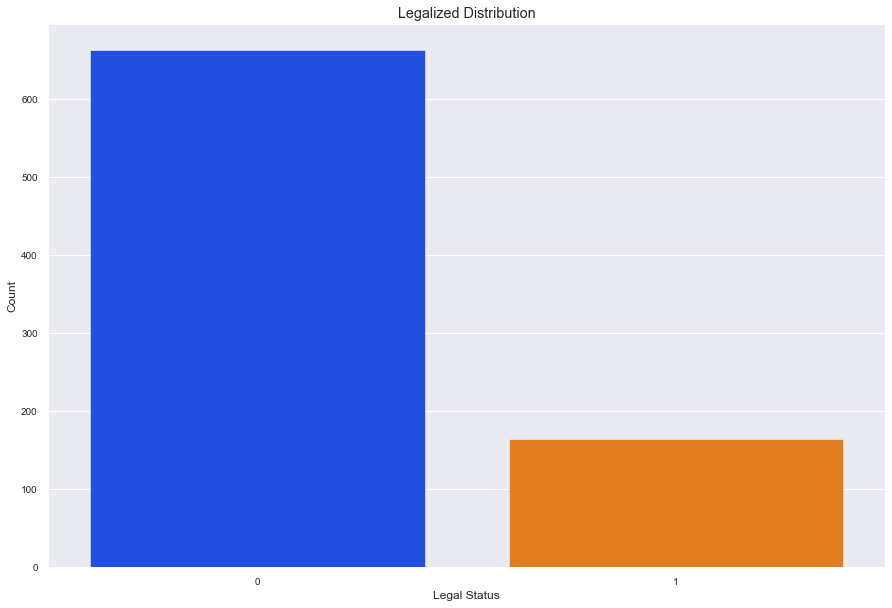

In [376]:
# check legalized distribution:

user_rating = df['Legalized'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Legal Status")
plt.ylabel("Count")
plt.title("Legalized Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

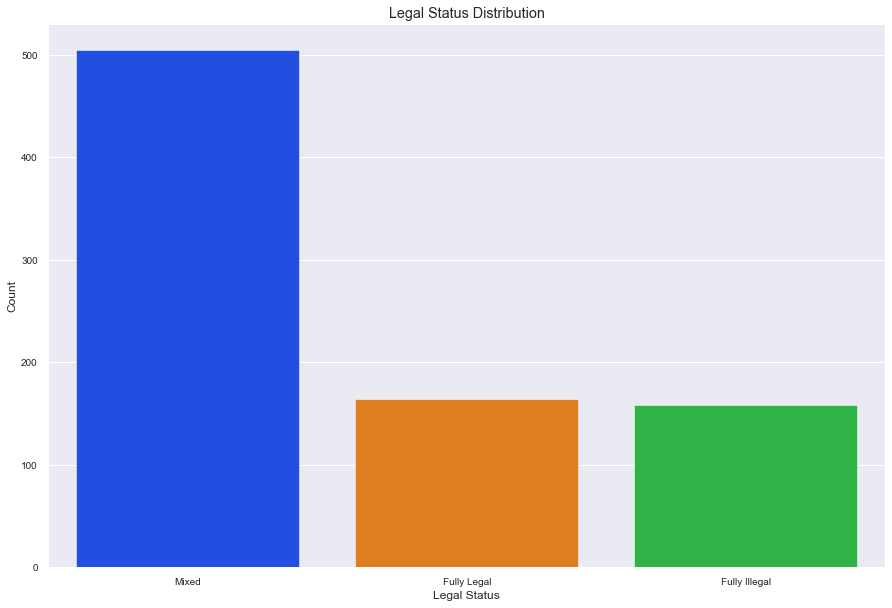

In [83]:
# check legal status distribution:

user_rating = df['LegalStatus'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Legal Status")
plt.ylabel("Count")
plt.title("Legal Status Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

In [274]:
print(df['LegalStatus'].value_counts())
df_copy['LegalStatus'].value_counts()
# df_copy[df_copy['LegalStatus']=='Fully Legal']

2    505
1    164
0    158
Name: LegalStatus, dtype: int64


Mixed            505
Fully Legal      164
Fully Illegal    158
Name: LegalStatus, dtype: int64

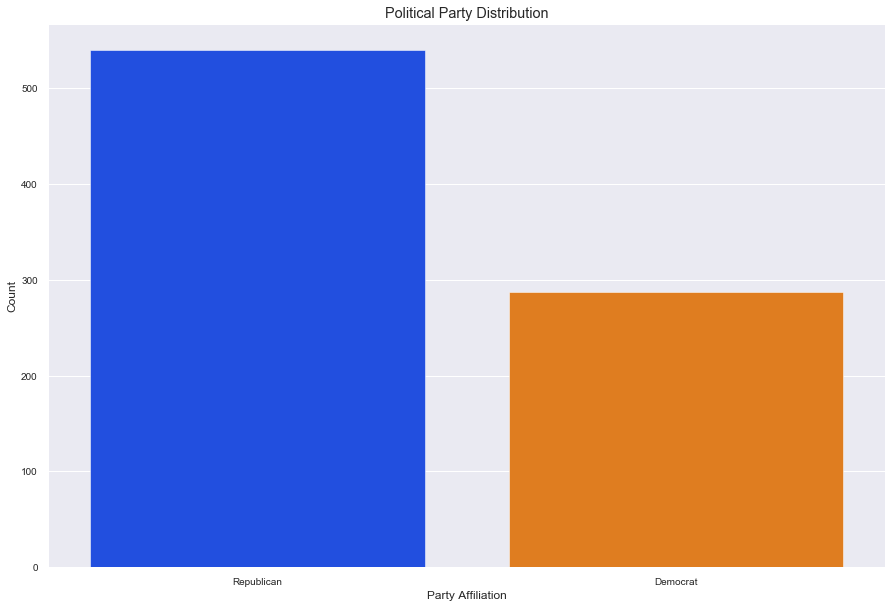

In [80]:
# check party affiliation distribution:

user_rating = df['PartyAffiliation'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Party Affiliation")
plt.ylabel("Count")
plt.title("Political Party Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

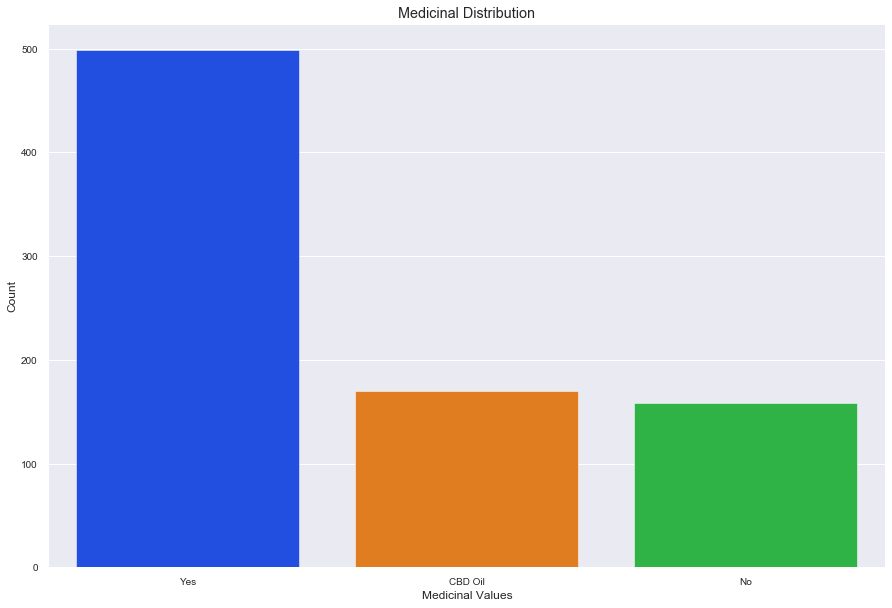

In [81]:
# check medicinal distribution:

user_rating = df['Medicinal'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Medicinal Values")
plt.ylabel("Count")
plt.title("Medicinal Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

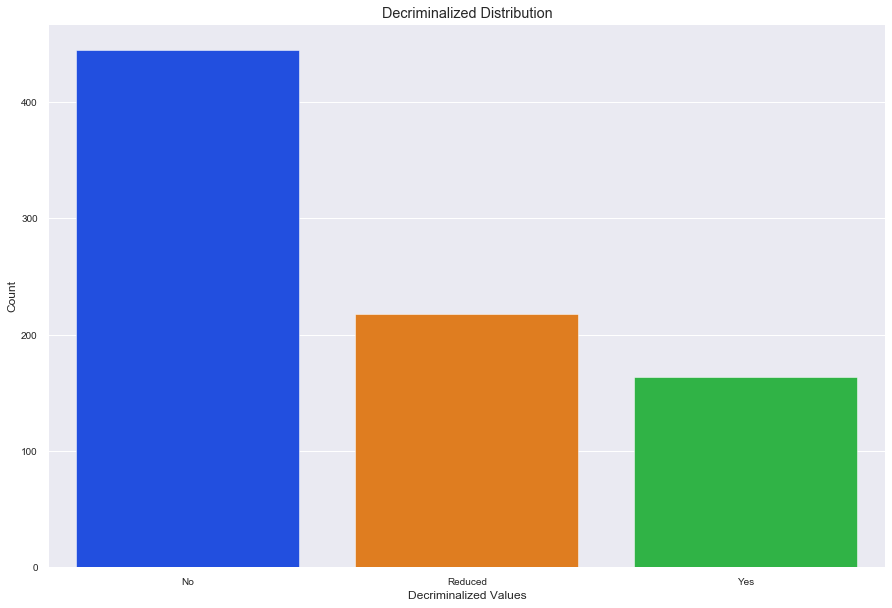

In [82]:
# check decriminalized distribution:

user_rating = df['Decriminalized'].value_counts()
plt.figure(figsize=(15,10))
plt.xlabel("Decriminalized Values")
plt.ylabel("Count")
plt.title("Decriminalized Distribution")
sns.barplot(user_rating.index, user_rating.values, palette='bright');

In [98]:
sc = df.select_dtypes(include ='object')
sc.columns

Index(['State_Code', 'LegalStatus'], dtype='object')

In [95]:
# make copy of dataframe:
# df_copy= df.copy()

df_copy.head()

,GeographicAreaName,EstimateSEXANDAGETotalpopulationMedianageyears,EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females,EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping,EstimateRACETotalpopulationOneraceAsianAsianIndian,EstimateRACETotalpopulationOneraceAsianFilipino,EstimateRACETotalpopulationOneraceAsianVietnamese,EstimateRACETotalpopulationOneraceAsianOtherAsian,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderGuamanianorChamorro,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderSamoan,EstimateRACETotalpopulationTwoormoreracesWhiteandAmericanIndianandAlaskaNative,EstimateRACETotalpopulationTwoormoreracesBlackorAfricanAmericanandAmericanIndianandAlaskaNative,EstimateRacealoneorincombinationwithoneormoreotherracesTotalpopulationAmericanIndianandAlaskaNative,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyracePuertoRican,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceCuban,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceOtherHispanicorLatino,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoBlackorAfricanAmericanalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoAmericanIndianandAlaskaNativealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoNativeHawaiianandOtherPacificIslanderalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoSomeotherracealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreraces,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreracesTworacesincludingSomeotherrace,EstimateHOUSINGTENUREOccupiedhousingunitsAveragehouseholdsizeofrenter_occupiedunit,EstimateHOUSEHEATINGFUELOccupiedhousingunitsBottledtankorLPgas,EstimateHOUSEHEATINGFUELOccupiedhousingunitsElectricity,EstimateHOUSEHEATINGFUELOccupiedhousingunitsFueloilkeroseneetc,EstimateHOUSEHEATINGFUELOccupiedhousingunitsCoalorcoke,EstimateHOUSEHEATINGFUELOccupiedhousingunitsWood,EstimateHOUSEHEATINGFUELOccupiedhousingunitsSolarenergy,EstimateHOUSEHEATINGFUELOccupiedhousingunitsOtherfuel,EstimateHOUSEHEATINGFUELOccupiedhousingunitsNofuelused,EstimateVALUEOwner_occupiedunitsLessthan50000,EstimateVALUEOwner_occupiedunits100000to149999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgageLessthan500,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgage500to999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageLessthan250,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage250to399,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage1000ormore,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageMediandollars,EstimateSELECTEDMONTHLYOWNERCOSTSASAPERCENTAGEOFHOUSEHOLDINCOMESMOCAPIHousingunitwithoutamortgageexcludingunitswhereSMOCAPIcannotbecomputedNotcomputed,EstimateGROSSRENTOccupiedunitspayingrentLessthan500,EstimateGROSSRENTOccupiedunitspayingrent500to999,EstimateGROSSRENTOccupiedunitspayingrentMediandollars,EstimateHOUSINGOCCUPANCYTotalhousingunitsVacanthousingunits,EstimateHOUSINGOCCUPANCYTotalhousingunitsHomeownervacancyrate,EstimateHOUSINGOCCUPANCYTotalhousingunitsRentalvacancyrate,EstimateUNITSINSTRUCTURETotalhousingunits1_unitattached,EstimateUNITSINSTRUCTURETotalhousingunits2units,EstimateUNITSINSTRUCTURETotalhousingunits3or4units,EstimateUNITSINSTRUCTURETotalhousingunitsMobilehome,EstimateUNITSINSTRUCTURETotalhousingunitsBoatRVvanetc,EstimateYEARSTRUCTUREBUILTTotalhousingunitsBuilt1939orearlier,EstimateROOMSTotalhousingunitsMedianrooms,EstimateEMPLOYMENTSTATUSPopulation16yearsandove

In [131]:
# cc = df.select_dtypes(include ='object')
# cc.columns
# 'GeographicAreaName',
# df.drop(['GeographicAreaName'],axis=1, inplace=True)

cc = ['GeographicAreaName','PartyAffiliation','Medicinal','Decriminalized']

for x in cc:
    df = pd.concat([df,pd.get_dummies(df[x], prefix=x)],axis=1)
    df.drop([x],axis=1, inplace=True)

# fix column headers for new columns:

df.columns.columns= df.columns.str.replace("'",'',regex=True)
df.columns= df.columns.str.replace(', ','_',regex=True)
df.columns= df.columns.str.replace(' ','_',regex=True)
df.columns= df.columns.str.replace('.','',regex=True)
    
# create features and target dataframes:

df_features = df.drop(['LegalStatus','State_Code'], axis=1)
df_target = pd.DataFrame(df['LegalStatus'])

df_features = df_features.astype(float)

KeyError: 'GeographicAreaName'

In [149]:
df_features = df_features.astype(float)

In [150]:
# df_features.head()
# df_target.head()

for x in df_features.columns:
    print(df_features[x].dtypes)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


In [1177]:
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime

import itertools
from itertools import combinations, cycle

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC, lasso_path, enet_path
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.feature_selection import VarianceThreshold, f_regression, mutual_info_regression, SelectKBest, RFE, RFECV
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from scipy import stats
import scipy.stats as st
from scipy.stats import shapiro

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [716]:
def prediction_function(model,train_x,test_x, train_y,test_y, estimate=None):
    
    cols = [i for i in df.columns if i not in df['Legalized']]
    
    model.fit(train_x,train_y)
    predictions = model.predict(test_x)
    probabilities = model.predict_proba(test_x)
    
    predict_train = model.predict(train_x)
    prob_train = model.predict_proba(train_x)
    
    
    if estimate == 'dec_tree':
        coefficients = pd.DataFrame(model.feature_importances_)
    elif estimate == 'rfe':
        coefficients = pd.DataFrame(model.estimator_.coef_.ravel())
    else:
        coefficients = pd.DataFrame(model.coef_.ravel())
    
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (model)
    print ("\n Score Report : \n",classification_report(test_y,predictions))
    print ("Accuracy Score : ",accuracy_score(test_y,predictions))
    print ('Training Root Mean Square Error',np.sqrt(metrics.mean_squared_error(train_y,predict_train)))
    print ('Testing Root Mean Square Error',np.sqrt(metrics.mean_squared_error(test_y,predictions)))
    
    
    c_matrix = confusion_matrix(test_y,predictions)
    cnf_matrix = pd.DataFrame(c_matrix)
    
    model_roc_auc = roc_auc_score(test_y,predictions) 
    print ("AUC : ",model_roc_auc,"\n")
    test_fpr,test_tpr,test_thresholds = roc_curve(test_y, probabilities[:,1])
    train_fpr,train_tpr,train_thresholds = roc_curve(train_y, prob_train[:,1])
    
    trace1 = go.Heatmap(z = cnf_matrix ,
                        x = [0,1],
                        y = [0,1],
                        showscale  = False,colorscale = "Viridis",
                        name = "matrix")
    
    trace2 = go.Scatter(x = test_fpr,y = test_tpr,
                        name = "ROC Test",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    trace4 = go.Scatter(x = train_fpr,y=train_tpr,
                        name= "ROC Train",
                        line = dict(color = ('rgb(255, 128, 0)'),width = 2))
    
    trace5 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('ROC Curve','Confusion Matrix','Feature Ranking'))
    
    fig.append_trace(trace1,1,2)
    fig.append_trace(trace2,1,1)
    fig.append_trace(trace3,1,1)
    fig.append_trace(trace4,1,1)
    fig.append_trace(trace5,2,1)
    
    fig['layout'].update(showlegend=False, title="Model Performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    
    py.iplot(fig)

In [553]:
def model_score(model,train_x,test_x,train_y,test_y,name):
    model.fit(train_x,train_y)
    predictions  = model.predict(test_x)
    accuracy     = accuracy_score(test_y,predictions)
    recallscore  = recall_score(test_y,predictions)
    precision    = precision_score(test_y,predictions)
    roc_auc      = roc_auc_score(test_y,predictions)
    f1score      = f1_score(test_y,predictions) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc]})
    return df


In [111]:
def model_compare(metric,color) :
    chart = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color))
    return chart

In [112]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))

In [563]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        
        output = X.copy()
        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [907]:
# use target encoding for categorical features:

def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)


## Intermediate Models

### Conduct Test of Legalized Field

In [1074]:
# instantiate encoders:
le = LabelEncoder()
ohc = OneHotEncoder()

# make copy of dataframe:
df = df_copy.copy()

# ============================================================================== #

# select columns to be removed:
dcol = [
'GeographicAreaName',
'State_Code',
'EstimateRACETotalpopulationTwoormoreracesWhiteandAmericanIndianandAlaskaNative',
'EstimateRACETotalpopulationTwoormoreracesBlackorAfricanAmericanandAmericanIndianandAlaskaNative',
'EstimateRacealoneorincombinationwithoneormoreotherracesTotalpopulationAmericanIndianandAlaskaNative',
'VoteDifferenceC_T',
'VoteDifferenceT_C',
'2012TotalVotes',
'ClintonBWObama',
'TrumpBWRomney',
'ClintonPctBWObama',
'TrumpPctBWRomney',
'2010LandArea',
'Density',
'CombinedFIPSCode',
'CountyFIPSCode',
'CBSACode',
'CSACode',
'MetropolitanDivisionCode']


for x in dcol:
    df.drop([x], axis=1, inplace=True)

# ============================================================================== #

# remove columns where constant value equals zero:
df = df.loc[:, (df != df.iloc[0]).any()] 

# ============================================================================== #

# create column for testing:
df['Legalized']=df['LegalStatus']

# update test column:
df.iloc[:,-1].replace('Fully Legal','Yes',inplace=True)
df.iloc[:,-1].replace('Fully Illegal','No',inplace=True)
df.iloc[:,-1].replace('Mixed','No',inplace=True)

# drop columns:
df.drop(['LegalStatus'], axis=1,inplace=True)
df.drop(['Decriminalized'], axis=1, inplace=True)

# label encoding:
df['PartyAffiliation']= le.fit_transform(df['PartyAffiliation'])
df['Legalized']= le.fit_transform(df['Legalized'])

# combine adherents:
df1['Mathematics_score']=df1['Mathematics1_score'] + df1['Mathematics2_score']
print(df1)



In [ ]:
print('LegalStatus = ',df_copy['LegalStatus'].unique())
print('Decriminalized = ',df_copy['Decriminalized'].unique())
print('Medicinal = ',df_copy['Medicinal'].unique())
print('PartyAffiliation = ',df_copy['PartyAffiliation'].unique())
print('Legalized = ',df['Legalized'].unique())

# LegalStatus =  ['Fully Illegal' 'Fully Legal' 'Mixed'];  Fully Illegal = 0, Mixed = 1, Fully Legal = 2
# Decriminalized =  ['No' 'Yes' 'Reduced']; No = 0, Reduced = 1, Yes = 2
# Medicinal =  ['No' 'Yes' 'CBD Oil']; No = 0, CBD Oil = 1, Yes = 2
# PartyAffiliation =  ['Republican' 'Democrat']; Label Encoder
# Legalized =  ['No' 'Yes']; Label Encoder

In [1062]:
# label encoding:

# df['PartyAffiliation']= le.fit_transform(df['PartyAffiliation'])
# df['Legalized']= le.fit_transform(df['Legalized'])

In [912]:
#target encoding:

# df['GeographicAreaName'] = calc_smooth_mean(df, by='GeographicAreaName', on='Legalized', m=10)

In [1046]:
# ordinal encoding:

# ordinalencoder = OrdinalEncoder()
# ordinalencoder.fit_transform(df[['LegalStatus']])

# # Using pandas factorize method for ordinal data
# categories1 = pd.Categorical(df['LegalStatus'], categories=['Fully Illegal', 'Mixed', 'Fully Legal'], ordered=True) # Order of labels set for data


# # Factorizing the column data
# labels1, unique = pd.factorize(categories1, sort=True)
# df['LegalStatus'] = labels1  # Encoded Legal Status


# ordinalencoder.fit_transform(df[['Decriminalized']])

# # Using pandas factorize method for ordinal data
# categories2 = pd.Categorical(df['Decriminalized'], categories=['No', 'Reduced', 'Yes'], ordered=True) # Order of labels set for data

# # Factorizing the column data
# labels2, unique = pd.factorize(categories2, sort=True)
# df['Decriminalized'] = labels2  # Encoded Legal Status


# ordinalencoder.fit_transform(df[['Medicinal']])

# # Using pandas factorize method for ordinal data
# categories3 = pd.Categorical(df['Medicinal'], categories=['No', 'CBD Oil', 'Yes'], ordered=True) # Order of labels set for data

# # Factorizing the column data
# labels3, unique = pd.factorize(categories3, sort=True)
# df['Medicinal'] = labels3  # Encoded Legal Status



In [1047]:
# binary encoding for all 50 states:

# import category_encoders as ce

# encoder = ce.BinaryEncoder(cols=['State_Code'])
# df = encoder.fit_transform(df)


In [1076]:
#target encoding:
chk = df.select_dtypes(include ='object')
c = chk.columns

for x in chk.columns:
    df[x] = calc_smooth_mean(df, by=x, on='Legalized', m=10)

In [1077]:
# check categorical columns:
chk = df.select_dtypes(include ='object')
chk.columns

Index([], dtype='object')

In [1078]:
# check for columns with zeros comprising at least 50%:
cols = list(df.columns[df[df == 0].count(axis=0)/len(df.index)>0.5])
cols

['EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping',
 'EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping',
 'EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping',
 'EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping',
 'EstimateRACETotalpopulationOneraceAsianAsianIndian',
 'EstimateRACETotalpopulationOneraceAsianFilipino',
 'EstimateRACETotalpopulationOneraceAsianVietnamese',
 'EstimateRACETotalpopulationOneraceAsianOtherAsian',
 'EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderGuamanianorChamorro',
 'EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderSamoan',
 'EstimateHOUSEHEATINGFUELOccupiedhousingunitsCoalorcoke',
 'EstimateHOUSEHEATINGFUELOccupiedhousingunitsSolarenergy',
 'EstimateFERTILITYNumberofwomen15to50yearsoldwhohadabirthinthepast12monthsPer1000women15to19yearsold',
 'EstimateWORLDREGIONOFBIRTHOF

In [1079]:
# find columns where zero count > 50%:
cols = list(df.columns[df[df == 0].count(axis=0)/len(df.index)>0.5])

# remove items that should not be dropped from dataframe:
# for x in ['State_Code_0','State_Code_1', 'State_Code_2', 'State_Code_3', 'State_Code_4','State_Code_5', 'State_Code_6',
# 'Legalized']:
#     cols.remove(x)

for x in ['Legalized']:
    cols.remove(x)
    
# drop columns from dataframe:
for x in cols:
    df.drop([x], axis=1,inplace=True)


In [1092]:
df.head()

,EstimateSEXANDAGETotalpopulationMedianageyears,EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females,EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyracePuertoRican,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceCuban,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceOtherHispanicorLatino,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoBlackorAfricanAmericanalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoAmericanIndianandAlaskaNativealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoNativeHawaiianandOtherPacificIslanderalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoSomeotherracealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreraces,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreracesTworacesincludingSomeotherrace,EstimateHOUSINGTENUREOccupiedhousingunitsAveragehouseholdsizeofrenter_occupiedunit,EstimateHOUSEHEATINGFUELOccupiedhousingunitsBottledtankorLPgas,EstimateHOUSEHEATINGFUELOccupiedhousingunitsElectricity,EstimateHOUSEHEATINGFUELOccupiedhousingunitsFueloilkeroseneetc,EstimateHOUSEHEATINGFUELOccupiedhousingunitsWood,EstimateHOUSEHEATINGFUELOccupiedhousingunitsOtherfuel,EstimateHOUSEHEATINGFUELOccupiedhousingunitsNofuelused,EstimateVALUEOwner_occupiedunitsLessthan50000,EstimateVALUEOwner_occupiedunits100000to149999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgageLessthan500,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgage500to999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageLessthan250,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage250to399,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage1000ormore,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageMediandollars,EstimateSELECTEDMONTHLYOWNERCOSTSASAPERCENTAGEOFHOUSEHOLDINCOMESMOCAPIHousingunitwithoutamortgageexcludingunitswhereSMOCAPIcannotbecomputedNotcomputed,EstimateGROSSRENTOccupiedunitspayingrentLessthan500,EstimateGROSSRENTOccupiedunitspayingrent500to999,EstimateGROSSRENTOccupiedunitspayingrentMediandollars,EstimateHOUSINGOCCUPANCYTotalhousingunitsVacanthousingunits,EstimateHOUSINGOCCUPANCYTotalhousingunitsHomeownervacancyrate,EstimateHOUSINGOCCUPANCYTotalhousingunitsRentalvacancyrate,EstimateUNITSINSTRUCTURETotalhousingunits1_unitattached,EstimateUNITSINSTRUCTURETotalhousingunits2units,EstimateUNITSINSTRUCTURETotalhousingunits3or4units,EstimateUNITSINSTRUCTURETotalhousingunitsMobilehome,EstimateUNITSINSTRUCTURETotalhousingunitsBoatRVvanetc,EstimateYEARSTRUCTUREBUILTTotalhousingunitsBuilt1939orearlier,EstimateROOMSTotalhousingunitsMedianrooms,EstimateEMPLOYMENTSTATUSPopulation16yearsandoverInlaborforceArmedForces,EstimateCOMMUTINGTOWORKWorkers16yearsandoverPublictransportationexcludingtaxicab,EstimateCOMMUTINGTOWORKWorkers16yearsandoverWalked,EstimateCOMMUTINGTOWORKWorkers16yearsandoverMeantraveltimetoworkminutes,EstimateINDUSTRYCivilianemployedpopulation16yearsandoverAgricultureforestryfishingandhuntingandmining,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSTotalhouseholdsWithSocialSecurityMeanSocialSecurityincomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSTotalhouseholdsWithretirementincomeMeanretirementincomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSTotalhouseholdsWithSupplementalSecurityIncomeMeanSupplementalSecurityIncomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSTotalhouseholdsWithcashpublicassistanceincomeMeancashpublicassistanceincomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSFamiliesMeanfamilyincomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSNonfamilyhouseholdsMeannonfamilyincomedollars,EstimateINCOMEANDBENEFITSIN2018INFLATION_ADJUSTEDDOLLARSMedianearningsfor

In [1091]:
# create features and target dataframes:

df_features = df.drop(['Legalized'], axis=1)
df_target = df['Legalized']

In [1093]:
profile_new = df.profile_report()
rejected_variables_new = profile_new.get_rejected_variables(threshold=0.9)


In [1094]:
rejected_variables_new

[]

In [ ]:
profile_new

### Train/Test Split

In [1096]:
X = df_features
y = df_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

logreg = LogisticRegression() 
baseline_log = logreg.fit(X_train, y_train)
print(baseline_log) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [1097]:
prediction_function(baseline_log, X_train, X_test, y_train, y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       131
           1       0.73      0.77      0.75        35

    accuracy                           0.89       166
   macro avg       0.83      0.85      0.84       166
weighted avg       0.89      0.89      0.89       166

Accuracy Score :  0.891566265060241
Training Root Mean Square Error 0.2130393839705269
Testing Root Mean Square Error 0.329292779969071
AUC :  0.8475463467829879 



### Scaling

In [1098]:
scaler = MinMaxScaler().fit(X_train)
X_trans = scaler.transform(X_train)
X_train_transformed = pd.DataFrame(X_trans, columns=X_train.columns, index=X_train.index)

In [1099]:
scaler = MinMaxScaler().fit(X_test)
X_testy = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_testy, columns=X_test.columns, index=X_test.index)

### SMOTE

In [1100]:
smote = SMOTE()
X_smote_train, y_smote_train = smote.fit_sample(X_train_transformed, y_train) 
X_smote_test, y_smote_test = smote.fit_sample(X_test_transformed, y_test) 
smote_log = LogisticRegression(fit_intercept = False, C = 1e12,solver ='lbfgs', random_state=123)
smote_logit = smote_log.fit(X_smote_train, y_smote_train) 

In [1101]:
prediction_function(smote_logit, X_smote_train, X_smote_test, y_smote_train, y_smote_test)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       131
           1       0.84      0.88      0.86       131

    accuracy                           0.85       262
   macro avg       0.86      0.85      0.85       262
weighted avg       0.86      0.85      0.85       262

Accuracy Score :  0.8549618320610687
Training Root Mean Square Error 0.14379392104440059
Testing Root Mean Square Error 0.38083876895469987
AUC :  0.8549618320610687 



In [ ]:
y_hats = model.predict(X)

df['y_hats'] = y_hats.reset_index()['name of the target column']

### Lasso Model

In [1102]:
log_lasso = LogisticRegression(penalty='l1', random_state=123)
logit_lasso = log_lasso.fit(X_train_transformed,y_train)
prediction_function(logit_lasso,X_train_transformed,X_test_transformed,y_train,y_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

           0       0.90      0.98      0.93       131
           1       0.87      0.57      0.69        35

    accuracy                           0.89       166
   macro avg       0.88      0.77      0.81       166
weighted avg       0.89      0.89      0.88       166

Accuracy Score :  0.891566265060241
Training Root Mean Square Error 0.3037835044059633
Testing Root Mean Square Error 0.329292779969071
AUC :  0.7742639040348964 



### Ridge Model (Balanced)

In [1103]:
ridge_logreg = LogisticRegression(class_weight='balanced', random_state=123)
ridge_logit = ridge_logreg.fit(X_train_transformed,y_train)

prediction_function(ridge_logit,X_train_transformed,X_test_transformed,y_train,y_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

 Score Report : 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90       131
           1       0.60      0.86      0.71        35

    accuracy                           0.85       166
   macro avg       0.78      0.85      0.80       166
weighted avg       0.88      0.85      0.86       166

Accuracy Score :  0.8493975903614458
Training Root Mean Square Error 0.3771057869934691
Testing Root Mean Square Error 0.38807526285316646
AUC :  0.8522355507088332 



### Recursive Feature Elimination (RFE)

In [1104]:
logit = LogisticRegression()
rfe = RFE(logit, 10)
X_rfe_train = rfe.fit_transform(X_train_transformed,y_train)
X_rfe_test = rfe.transform(X_test_transformed)
rfe = rfe.fit(X_rfe_train,y_train.values.ravel())
prediction_function(rfe,X_rfe_train,X_rfe_test,y_train,y_test, 'rfe')

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='warn', n_jobs=None, penalty='l2',
                                 random_state=None, solver='warn', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

 Score Report : 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       131
           1       0.83      0.57      0.68        35

    accuracy                           0.89       166
   macro avg       0.86      0.77      0.80       166
weighted avg       0.88      0.89      0.88       166

Accuracy Score :  0.8855421686746988
Training Root Mean Square Error 0.3368448423330154
Testing Root Mean Square Error 0.33831617065298725
AUC :  0.7704471101417666 



## Advanced Models

### Principal Component Analysis (PCA)

In [1105]:
pca_X2 = df_features
pca_y2 = df_target

pca_X_train2, pca_X_test2, pca_y_train2, pca_y_test2 = train_test_split(pca_X2, pca_y2, test_size=0.20, random_state=123)


In [1106]:
pca = PCA()
pca_train = pca.fit_transform(pca_X_train_transformed2)
pca_test = pca.transform(pca_X_test_transformed2)

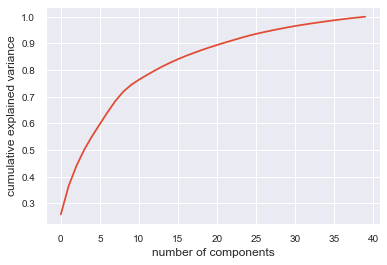

In [1107]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [1108]:
pca = PCA(n_components=15)
pca_X_train_transformed2 = pca.fit_transform(pca_X_train_transformed2)
pca_X_test_transformed2 = pca.transform(pca_X_test_transformed2)

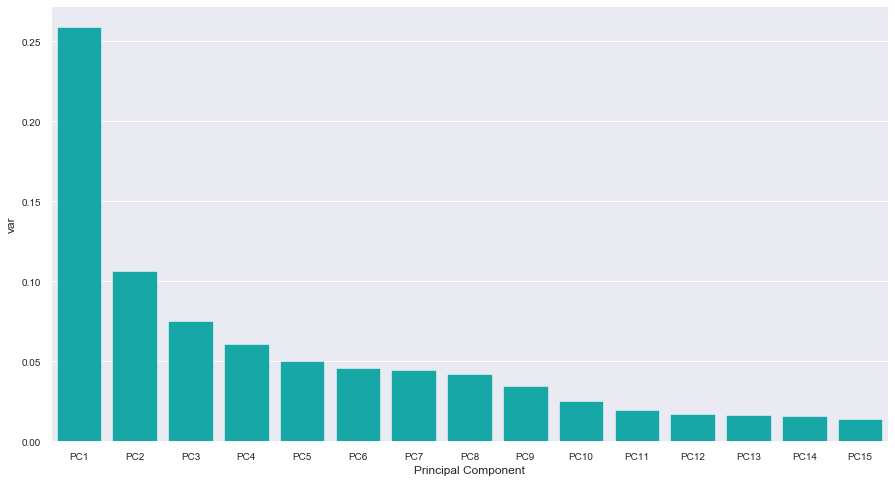

In [1109]:
pca_df = pd.DataFrame({'var': pca.explained_variance_ratio_, 'Principal Component': ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                                                                   'PC11', 'PC12', 'PC13', 'PC14','PC15']})
#                                                                     ,'PC16','PC17','PC18','PC19','PC20',
#                                                                    'PC21', 'PC22', 'PC23', 'PC24','PC25','PC26','PC27','PC28','PC29','PC30',
#                                                                    'PC31', 'PC32', 'PC33', 'PC34','PC35','PC36','PC37','PC38','PC39','PC40']})
plt.figure(figsize=(15,8))
sns.barplot(x='Principal Component', y='var', data=pca_df, color='c');

In [1169]:
print (pca.explained_variance_ratio_)

[0.25887926 0.10644667 0.07540694 0.06083756 0.05031476 0.0457563
 0.04478956 0.0420525  0.0344723  0.02515408 0.01945567 0.01730733
 0.01665715 0.01578677 0.01407092]


### Decision Tree

In [1110]:
X2 = df_features
y2 = df_target

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=123)

In [1111]:
mm_scaler = MinMaxScaler().fit(X_train2)
X_trans2 = mm_scaler.transform(X_train2)
X_train_transformed2 = pd.DataFrame(X_trans2, columns=X_train2.columns, index=X_train2.index)

mm_scaler = MinMaxScaler().fit(X_test2)
X_testy2 = mm_scaler.transform(X_test2)
X_test_transformed2 = pd.DataFrame(X_testy2, columns=X_test2.columns, index=X_test2.index)

In [1112]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123, class_weight='balanced')
dec_tree = clf_tree.fit(X_train_transformed2, y_train2)

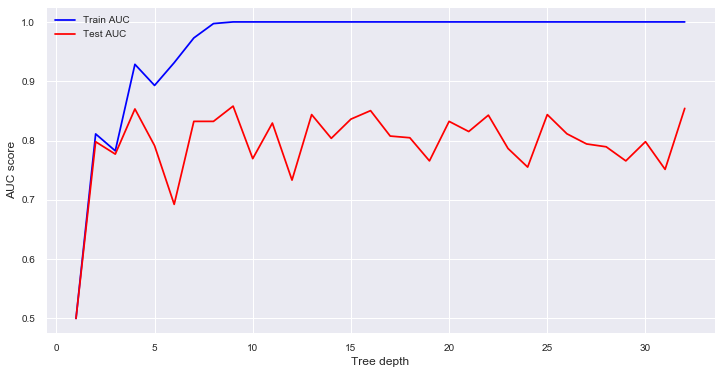

In [1113]:
y_pred = clf_tree.predict(X_test_transformed2)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
   dt.fit(X_train_transformed2, y_train2)
   train_pred = dt.predict(X_train_transformed2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train2, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test_transformed2)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test2, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

In [1114]:
prediction_function(dec_tree,X_train_transformed2,X_test_transformed2,y_train2,y_test2,estimate='dec_tree')

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

 Score Report : 
               precision    recall  f1-score   support

           0       0.87      0.90      0.89       131
           1       0.58      0.51      0.55        35

    accuracy                           0.82       166
   macro avg       0.73      0.71      0.72       166
weighted avg       0.81      0.82      0.82       166

Accuracy Score :  0.8192771084337349
Training Root Mean Square Error 0.12299834568337577
Testing Root Mean Square Error 0.4251151509488518
AUC :  0.7075245365321701 



### Random Forest

In [1115]:
baseline_forest = RandomForestClassifier()
mean_baseline_forest = np.mean(cross_val_score(baseline_forest, X_train_transformed2, y_train2, cv=3))

print(f"Mean Cross Val Score for Random Forest: {mean_baseline_forest :.2%}")

Mean Cross Val Score for Random Forest: 86.38%


In [1116]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [1117]:
rf_grid_search = GridSearchCV(baseline_forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train_transformed2, y_train2)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 89.26%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [1118]:
forest = RandomForestClassifier(criterion='entropy', max_depth=6, min_samples_leaf=3, min_samples_split=5, n_estimators=10)
forest.fit(X_train_transformed2, y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1119]:
forest.score(X_train_transformed2, y_train2)

0.9636913767019667

In [1120]:
forest.score(X_test_transformed2, y_test2)

0.8433734939759037

In [1200]:
# random forest feature importance:
n=10
col_sorted_by_importance=forest.feature_importances_.argsort()[::-1][:n]
feat_imp=pd.DataFrame({
    'Features':X_train_transformed2.columns[col_sorted_by_importance],
    'Importance':forest.feature_importances_[col_sorted_by_importance]
})

import plotly.express as px
px.bar(feat_imp, x='Features', y='Importance',title="Random Forest Feature Importance")

### XGBoost

In [1121]:
xgb_clf_baseline = xgb.XGBClassifier()
xgb_clf_baseline.fit(X_train_transformed2, y_train2)
training_preds = xgb_clf_baseline.predict(X_train_transformed2)
val_preds = xgb_clf_baseline.predict(X_test_transformed2)
training_accuracy = accuracy_score(y_train2, training_preds)
val_accuracy = accuracy_score(y_test2, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 90.36%


In [1122]:
param_grid = {
    "learning_rate": [1.0, 0.5, 0.1, 0.01],
    'max_depth': [1, 2, 4, 6, 10],
    'min_child_weight': [10],
    'subsample': [0.7, 0.8],
    'n_estimators': [3, 5, 30, 100, 250],
}

In [1123]:
grid_clf = GridSearchCV(xgb_clf_baseline, param_grid, scoring='accuracy', cv=3, n_jobs=4)
grid_clf.fit(X_train_transformed2, y_train2)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 4
min_child_weight: 10
n_estimators: 250
subsample: 0.7


In [1124]:
xgb_clf = xgb.XGBClassifier(learning_rate=1.0, max_depth=2, min_child_weight=10, n_estimators=5, subsample=0.7)
xgb_clf.fit(X_train_transformed2, y_train2)
training_preds = xgb_clf.predict(X_train_transformed2)
val_preds = xgb_clf.predict(X_test_transformed2)
training_accuracy = accuracy_score(y_train2, training_preds)
val_accuracy = accuracy_score(y_test2, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 91.68%
Validation accuracy: 80.72%


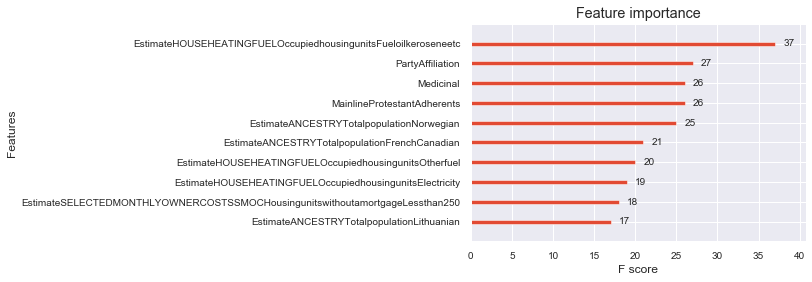

In [1216]:
# top 10 xgbost features:
xgb.plot_importance(xgb_clf_baseline,max_num_features=10)
pyplot.show()

In [1213]:
# xgboost feature importance:
n=10
col_sorted_by_importance=xgb_clf_baseline.feature_importances_.argsort()[::-1][:n]
feat_imp=pd.DataFrame({
    'Features':X_train_transformed2.columns[col_sorted_by_importance],
    'Importance':xgb_clf_baseline.feature_importances_[col_sorted_by_importance]
})

import plotly.express as px
px.bar(feat_imp, x='Features', y='Importance',title="XGBoost Feature Importance")

### AdaBoost Classifier

In [1125]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=123)
adaboost_clf.fit(X_train_transformed2, y_train2)
adaboost_train_preds = adaboost_clf.predict(X_train_transformed2)
adaboost_test_preds = adaboost_clf.predict(X_test_transformed2)

In [1126]:
adaboost_confusion_matrix = confusion_matrix(y_test2, adaboost_test_preds)
adaboost_confusion_matrix

array([[128,   3],
       [ 22,  13]])

In [1127]:
print("AdaBoost Training Metrics")
display_acc_and_f1_score(y_train2, adaboost_train_preds, model_name='AdaBoost')
print("")
print("AdaBoost Testing Metrics")
display_acc_and_f1_score(y_test2, adaboost_test_preds, model_name='AdaBoost')
print("")

AdaBoost Training Metrics
Model: AdaBoost
Accuracy: 1.0
F1-Score: 1.0

AdaBoost Testing Metrics
Model: AdaBoost
Accuracy: 0.8493975903614458
F1-Score: 0.5098039215686275



In [1128]:
adaboost_classification_report = classification_report(y_test2, adaboost_test_preds)
print(adaboost_classification_report)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       131
           1       0.81      0.37      0.51        35

    accuracy                           0.85       166
   macro avg       0.83      0.67      0.71       166
weighted avg       0.84      0.85      0.83       166



In [1129]:
print('Mean Adaboost Cross-Val Score (k=5):')
print(cross_val_score(adaboost_clf, X2, y2, cv=5).mean())

Mean Adaboost Cross-Val Score (k=5):
0.8355796578776303


In [1130]:
adaboost_param_grid = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [1.0, 0.5, 0.1]
}

In [1131]:
adaboost_grid_search = GridSearchCV(adaboost_clf, adaboost_param_grid, cv=3)
adaboost_grid_search.fit(X_train_transformed2, y_train2)

print(f"Training Accuracy: {adaboost_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {adaboost_grid_search.best_params_}")

Training Accuracy: 89.26%

Optimal Parameters: {'learning_rate': 0.5, 'n_estimators': 250}


In [1132]:
adb_score = adaboost_grid_search.score(X_test_transformed2, y_test2)
print('Adaboost grid search: ', adb_score)

Adaboost grid search:  0.8433734939759037


In [1208]:
# adaboost feature importance:
n=10
col_sorted_by_importance=adaboost_clf.feature_importances_.argsort()[::-1][:n]
feat_imp=pd.DataFrame({
    'Features':X_train_transformed2.columns[col_sorted_by_importance],
    'Importance':adaboost_clf.feature_importances_[col_sorted_by_importance]
})

import plotly.express as px
px.bar(feat_imp, x='Features', y='Importance',title="AdaBoost Feature Importance")

<a id="5.11"></a>

### Gradient Boosting Classifier

In [1133]:
# Instantiate a GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=123)
gbt_clf.fit(X_train_transformed2, y_train2)
gbt_clf_train_preds = gbt_clf.predict(X_train_transformed2)
gbt_clf_test_preds = gbt_clf.predict(X_test_transformed2)

In [1134]:
gbt_confusion_matrix = confusion_matrix(y_test2, gbt_clf_test_preds)
gbt_confusion_matrix

array([[127,   4],
       [ 10,  25]])

In [1135]:
print("GBT Training Metrics")
display_acc_and_f1_score(y_train2, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("GBT Testing Metrics")
display_acc_and_f1_score(y_test2, gbt_clf_test_preds, model_name='Gradient Boosted Trees')

GBT Training Metrics
Model: Gradient Boosted Trees
Accuracy: 1.0
F1-Score: 1.0

GBT Testing Metrics
Model: Gradient Boosted Trees
Accuracy: 0.9156626506024096
F1-Score: 0.7812500000000001


In [1136]:
gbt_classification_report = classification_report(y_test2, gbt_clf_test_preds)
print(gbt_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       131
           1       0.86      0.71      0.78        35

    accuracy                           0.92       166
   macro avg       0.89      0.84      0.86       166
weighted avg       0.91      0.92      0.91       166



In [1137]:
print('Mean GBT Cross-Val Score (k=5):')
print(cross_val_score(gbt_clf, X2, y2, cv=5).mean())

Mean GBT Cross-Val Score (k=5):
0.865759000525383


In [1218]:
# gradient boost feature importance:

n=10
col_sorted_by_importance=gbt_clf.feature_importances_.argsort()[::-1][:n]
feat_imp=pd.DataFrame({
    'Features':X_train_transformed2.columns[col_sorted_by_importance],
    'Importance':gbt_clf.feature_importances_[col_sorted_by_importance]
})

import plotly.express as px
px.bar(feat_imp, x='Features', y='Importance',title="Gradient Boost Feature Importance")

<a id="5.12"></a>

### K-Nearest Neighbors

In [1138]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed2, y_train2)
knn_clf_train_preds = knn_clf.predict(X_train_transformed2)
knn_clf_test_preds = knn_clf.predict(X_test_transformed2)

In [1139]:
knn_confusion_matrix = confusion_matrix(y_test2, knn_clf_test_preds)
knn_confusion_matrix

array([[122,   9],
       [  9,  26]])

In [1140]:
print("KNN Training Metrics")
display_acc_and_f1_score(y_train2, knn_clf_train_preds, model_name='K-Nearest Neighbors')
print("")
print("KNN Testing Metrics")
display_acc_and_f1_score(y_test2, knn_clf_test_preds, model_name='K-Nearest Neighbors')

KNN Training Metrics
Model: K-Nearest Neighbors
Accuracy: 0.9379727685325264
F1-Score: 0.844106463878327

KNN Testing Metrics
Model: K-Nearest Neighbors
Accuracy: 0.891566265060241
F1-Score: 0.7428571428571429


In [1141]:
knn_classification_report = classification_report(y_test2, knn_clf_test_preds)
print(knn_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       131
           1       0.74      0.74      0.74        35

    accuracy                           0.89       166
   macro avg       0.84      0.84      0.84       166
weighted avg       0.89      0.89      0.89       166



In [1142]:
print('Mean KNN Cross-Val Score (k=5):')
print(cross_val_score(knn_clf, X2, y2, cv=5).mean())

Mean KNN Cross-Val Score (k=5):
0.7858372737068006


<a id="5.13"></a>

### Ensemble / Meta-Classifier

In [1143]:
eclf = VotingClassifier(estimators=[('KNN', knn_clf), ('GBT', gbt_clf), ('XGB', xgb_clf), ('RF', forest)], voting='soft')
eclf.fit(X_train_transformed2, y_train2)
eclf_train_preds = eclf.predict(X_train_transformed2)
eclf_test_preds = eclf.predict(X_test_transformed2)

In [1144]:
print("ECLF Training Metrics")
display_acc_and_f1_score(y_train2, eclf_train_preds, model_name='ECLF')
print("")
print("ECLF Testing Metrics")
display_acc_and_f1_score(y_test2, eclf_test_preds, model_name='ECLF')
print("")

ECLF Training Metrics
Model: ECLF
Accuracy: 0.9909228441754917
F1-Score: 0.9761904761904763

ECLF Testing Metrics
Model: ECLF
Accuracy: 0.8674698795180723
F1-Score: 0.6451612903225806



In [1145]:
eclf_classification_report = classification_report(y_test2, eclf_test_preds)
print(eclf_classification_report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       131
           1       0.74      0.57      0.65        35

    accuracy                           0.87       166
   macro avg       0.82      0.76      0.78       166
weighted avg       0.86      0.87      0.86       166



### Model Comparison - Intermediate


In [1146]:
model1 = model_score(baseline_log, X_train, X_test, y_train, y_test,"Baseline")
model2 = model_score(smote_logit, X_smote_train, X_smote_test, y_smote_train, y_smote_test,"SMOTE")
model3 = model_score(rfe,X_rfe_train,X_rfe_test,y_train,y_test,"RFE")
model4 = model_score(logit_lasso,X_train_transformed,X_test_transformed,y_train,y_test,"Lasso")
model5 = model_score(ridge_logit,X_train_transformed,X_test_transformed,y_train,y_test, "Ridge")

model_performances = pd.concat([model1,model2,model3,model4,model5],axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1)

dataframe  = ff.create_table(np.round(model_performances,4))

py.iplot(dataframe)

In [1147]:
model_performances

layout = go.Layout(dict(title = "Model Comparison",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780))

trace1  = model_compare("Accuracy_score","#1bde65")
trace2  = model_compare('Recall_score',"#d93311")
trace3  = model_compare('Precision',"#3ae8d7")
trace4  = model_compare('f1_score',"#0f3175")

data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

<a id="6.2"></a>

### Model Comparison - Advanced

In [1148]:
def ML_model_score(model,train_x,test_x,train_y,test_y,name):
    model.fit(train_x,train_y)
    predictions  = model.predict(test_x)
    accuracy     = accuracy_score(test_y,predictions)
    recallscore  = recall_score(test_y,predictions)
    precision    = precision_score(test_y,predictions)
    roc_auc      = roc_auc_score(test_y,predictions)
    f1score      = f1_score(test_y,predictions) 
    cross_val    = cross_val_score(model,X2, y2, cv=5).mean()
    df_ML = pd.DataFrame({"Model"           : [name],
                       "Cross_Val"       : [cross_val],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc]})
    return df_ML

In [1149]:
ML_model1 = ML_model_score(dec_tree, X_train_transformed2, X_test_transformed2, y_train2, y_test2,"Decision Tree")
ML_model2 = ML_model_score(forest, X_train_transformed2, X_test_transformed2, y_train2, y_test2,"Random Forest")
ML_model3 = ML_model_score(xgb_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2,"XGBoost")
ML_model4 = ML_model_score(adaboost_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2,"AdaBoost")
ML_model5 = ML_model_score(gbt_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2, "GBT")
ML_model6 = ML_model_score(knn_clf,X_train_transformed2, X_test_transformed2, y_train2, y_test2, "KNN")

ML_model_performances = pd.concat([ML_model1,ML_model2,ML_model3,ML_model4,ML_model5,ML_model6],axis = 0).reset_index()
ML_model_performances = ML_model_performances.drop(columns = "index",axis =1)

ML_dataframe  = ff.create_table(np.round(ML_model_performances,4))

py.iplot(ML_dataframe)

In [1150]:
def ML_model_compare(metric,color) :
    ML_chart = go.Bar(y = ML_model_performances["Model"] ,
                    x = ML_model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color))
    return ML_chart

In [1151]:
ML_model_performances

layout = go.Layout(dict(title = "ML Model Comparison",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "Metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780))

trace1  = ML_model_compare("Accuracy_score","#1bde65")
trace2  = ML_model_compare('Recall_score',"#d93311")
trace3  = ML_model_compare('Precision',"#3ae8d7")
trace4  = ML_model_compare('f1_score',"#0f3175")
trace5  = ML_model_compare('Cross_Val', "#ddf50a")
data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [1281]:
# logistic regression predictions:

df_pred = df_copy.copy()
# create column for testing:
df_pred['Legalized']=df_pred['LegalStatus']

# update test column:
df_pred.iloc[:,-1].replace('Fully Legal','Yes',inplace=True)
df_pred.iloc[:,-1].replace('Fully Illegal','No',inplace=True)
df_pred.iloc[:,-1].replace('Mixed','No',inplace=True)

lrp = logreg.predict(X)
smt = smote_log.predict(X) #
las = log_lasso.predict(X) #
rid = ridge_logreg.predict(X) #
# rfelim = rfe.predict(X) #
# pca1 = pca.predict(X)
dt = dec_tree.predict(X) #
rf = forest.predict(X) #
xgb = xgb_clf.predict(X) #
adb = adaboost_clf.predict(X) #
gbc = gbt_clf.predict(X) #
knn = knn_clf.predict(X) #
ens = eclf.predict(X)

df_pred['LogRegPred'] = lrp
df_pred['SMOTEPred'] = smt
df_pred['LassoPred'] = las
df_pred['RidgePred'] = rid
# df_pred['RFEPred'] = rfelim
# df_pred['PCAPred'] = pca1
df_pred['DecisionTreePred'] = dt
df_pred['RandomForestPred'] = rf
df_pred['XGBoostPred'] = xgb
df_pred['AdaBoostPred'] = adb
df_pred['GradientBoostPred'] = gbc
df_pred['KNNPred'] = knn
df_pred['EnsemblePred'] = ens


df.columns[-2]
legal = ['Alaska','California','Colorado','Maine','Massachusetts','Nevada',
'Oregon','Washington','Illinois','Michigan','Vermont']

In [1340]:
# find out states from model predictions:
z=[]
for x in df_pred.columns[-11:]:
    z.append((np.unique(df_pred['State_Code'].loc[(df_pred[x] == 1) & (df_pred['Legalized'] =='No')].unique())))

# flatten nested list:
flatList = []
for elem in z:
    for item in elem:
        flatList.append(item)
# print('Flat List : ', flatList)

# get model counts for each state and sort in descending order:
counts,values = pd.Series(flatList).value_counts().values, pd.Series(flatList).value_counts().index
df_results = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])
df_results

,value,count
0,New York,7
1,New Mexico,7
2,New Hampshire,5
3,Texas,5
4,Idaho,5
5,Hawaii,5
6,Wisconsin,4
7,Tennessee,4
8,Florida,4
9,Indiana,4


In [1355]:
np.unique(df_pred['State_Code'].loc[(df_pred['KNNPred'] == 1) & (df_pred['Legalized'] =='No')].unique())

array(['Alabama', 'Arizona', 'Arkansas', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Indiana', 'Kentucky', 'Louisiana', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'New Hampshire',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas',
       'West Virginia', 'Wisconsin'], dtype=object)

In [1356]:
np.unique(df_pred['State_Code'].loc[(df_pred['GradientBoostPred'] == 1) & (df_pred['Legalized'] =='No')].unique())

array(['Connecticut', 'Delaware', 'Florida', 'Hawaii', 'Idaho', 'Indiana',
       'Iowa', 'Kentucky', 'Maryland', 'Minnesota', 'Montana',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Dakota', 'Ohio', 'Pennsylvania', 'Rhode Island',
       'Tennessee', 'Texas', 'Utah', 'Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [1352]:
# counts,values = df_pred.values(), df_pred.index
# df_results = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])

fig = px.bar(df_results, x='value', y='count')
fig.show()

In [1341]:
df_pred.head()

,GeographicAreaName,EstimateSEXANDAGETotalpopulationMedianageyears,EstimateSEXANDAGETotalpopulation18yearsandoverSexratiomalesper100females,EstimateSEXANDAGETotalpopulation65yearsandoverSexratiomalesper100females,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeCherokeetribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeChippewatribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeNavajotribalgrouping,EstimateRACETotalpopulationOneraceAmericanIndianandAlaskaNativeSiouxtribalgrouping,EstimateRACETotalpopulationOneraceAsianAsianIndian,EstimateRACETotalpopulationOneraceAsianFilipino,EstimateRACETotalpopulationOneraceAsianVietnamese,EstimateRACETotalpopulationOneraceAsianOtherAsian,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderGuamanianorChamorro,EstimateRACETotalpopulationOneraceNativeHawaiianandOtherPacificIslanderSamoan,EstimateRACETotalpopulationTwoormoreracesWhiteandAmericanIndianandAlaskaNative,EstimateRACETotalpopulationTwoormoreracesBlackorAfricanAmericanandAmericanIndianandAlaskaNative,EstimateRacealoneorincombinationwithoneormoreotherracesTotalpopulationAmericanIndianandAlaskaNative,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyracePuertoRican,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceCuban,EstimateHISPANICORLATINOANDRACETotalpopulationHispanicorLatinoofanyraceOtherHispanicorLatino,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoBlackorAfricanAmericanalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoAmericanIndianandAlaskaNativealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoNativeHawaiianandOtherPacificIslanderalone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoSomeotherracealone,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreraces,EstimateHISPANICORLATINOANDRACETotalpopulationNotHispanicorLatinoTwoormoreracesTworacesincludingSomeotherrace,EstimateHOUSINGTENUREOccupiedhousingunitsAveragehouseholdsizeofrenter_occupiedunit,EstimateHOUSEHEATINGFUELOccupiedhousingunitsBottledtankorLPgas,EstimateHOUSEHEATINGFUELOccupiedhousingunitsElectricity,EstimateHOUSEHEATINGFUELOccupiedhousingunitsFueloilkeroseneetc,EstimateHOUSEHEATINGFUELOccupiedhousingunitsCoalorcoke,EstimateHOUSEHEATINGFUELOccupiedhousingunitsWood,EstimateHOUSEHEATINGFUELOccupiedhousingunitsSolarenergy,EstimateHOUSEHEATINGFUELOccupiedhousingunitsOtherfuel,EstimateHOUSEHEATINGFUELOccupiedhousingunitsNofuelused,EstimateVALUEOwner_occupiedunitsLessthan50000,EstimateVALUEOwner_occupiedunits100000to149999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgageLessthan500,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithamortgage500to999,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageLessthan250,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage250to399,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgage1000ormore,EstimateSELECTEDMONTHLYOWNERCOSTSSMOCHousingunitswithoutamortgageMediandollars,EstimateSELECTEDMONTHLYOWNERCOSTSASAPERCENTAGEOFHOUSEHOLDINCOMESMOCAPIHousingunitwithoutamortgageexcludingunitswhereSMOCAPIcannotbecomputedNotcomputed,EstimateGROSSRENTOccupiedunitspayingrentLessthan500,EstimateGROSSRENTOccupiedunitspayingrent500to999,EstimateGROSSRENTOccupiedunitspayingrentMediandollars,EstimateHOUSINGOCCUPANCYTotalhousingunitsVacanthousingunits,EstimateHOUSINGOCCUPANCYTotalhousingunitsHomeownervacancyrate,EstimateHOUSINGOCCUPANCYTotalhousingunitsRentalvacancyrate,EstimateUNITSINSTRUCTURETotalhousingunits1_unitattached,EstimateUNITSINSTRUCTURETotalhousingunits2units,EstimateUNITSINSTRUCTURETotalhousingunits3or4units,EstimateUNITSINSTRUCTURETotalhousingunitsMobilehome,EstimateUNITSINSTRUCTURETotalhousingunitsBoatRVvanetc,EstimateYEARSTRUCTUREBUILTTotalhousingunitsBuilt1939orearlier,EstimateROOMSTotalhousingunitsMedianrooms,EstimateEMPLOYMENTSTATUSPopulation16yearsandove

In [1343]:
feat = [
'Employment Industry',
'Religion',
'Ancestry',
'Ancestry',
'Commute-Walk',
'Ancestry',
'Ancestry',
'Home Heating Fuel - Other',
'Ancestry',
'Ancestry',
'Ancestry',
'Home Heating Fuel - Wood',
'Ancestry',
'Ancestry',
'Ancestry',
'Ancestry',
'Ancestry',
'Fertility',
'Medicinal',
'Ancestry',
'Home Heating Fuel - Wood',
'Ancestry',
'Ancestry',
'Fertility',
'Ancestry',
'Religion',
'Commute-Walk',
'Race',
'Sex and Age Median',
'Race',
'Sex and Age per 100 females - 65 and over',
'Race',
'Sex and Age per 100 females - 18 and over',
'Race',
'Race',
'Race',
'Party Affiliation',
'Home Heating Fuel - Oil',
'Race',
'Ancestry',
'Housing Costs',
'Race',
'House Tenure',
'Ancestry',
'Ancestry',
'Medicinal',
'Party Affiliation',
'Ancestry',
'Home Value',
'Ancestry',
'Party Affiliation',
'Home Heating Fuel - Other',
'Relgion',
'Ancestry',
'Party Affiliation',
'Medicinal',
'Home Heating Fuel - Electricity',
'Home Heating Fuel - Wood',
'Home Structure',
'Population',
'Number of Rooms in Home',
'Home Heating Fuel - Oil',
'Employment Industry',
'Religion',
'Home Heating Fuel - Oil',
'Ancestry',
'Party Affiliation',
'Home Vacancy Rate',
'Housing Costs',
'Population',
'Employment Industry',
'Housing Costs',
'Party Affiliation',
'Home Heating Fuel - Oil',
'Ancestry',
'Home Heating Fuel - Wood',
'Home Heating Fuel - Electricity',
'Number of Rooms in Home',
'Medicinal',
'Employment Industry',
'Ancestry'
]

In [1344]:
counts,values = pd.Series(feat).value_counts().values, pd.Series(feat).value_counts().index
df_feat = pd.DataFrame(list(zip(values,counts)),columns=["value","count"])
df_feat

,value,count
0,Ancestry,25
1,Race,8
2,Party Affiliation,6
3,Medicinal,4
4,Employment Industry,4
5,Home Heating Fuel - Wood,4
6,Home Heating Fuel - Oil,4
7,Religion,3
8,Housing Costs,3
9,Fertility,2


In [1354]:
fig = px.bar(df_feat, x='value', y='count')
fig.show()